# Todo list:
- Graph yapısı için node ve edge özelliklerinde kullanılacak yeni featurelar çıkarılacak
- Evaluate ve visualize etmek için yeni methodlar eklenecek
- Supervised yaklaşım için node classificaiton'a ek olarak link prediction embeddingleri denenecek. Bunun için yeni data process kodları yazılacak
- Unsupervised ve semi-supervised yöntemler kullanılarak embedding oluşturulacak ve evaluate edilecek
- Supervised yaklaşımlar için hyperparametre araması yapılacak
- Data preprocess geliştirilecek
- Object oriented structure refactor edilecek
- EDA detaylandırılacak, bulgulara göre üstteki maddelerde değişikliğe gidilecek
- Embedding görselleştirmeleri arttırılacak

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import torch
from torch_geometric.nn import (
    Node2Vec,
    GCNConv,
    GATConv,
    SAGEConv,
    GINConv,
    TransformerConv,
)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE,Isomap
#import umap
from sklearn.cluster import KMeans,  DBSCAN
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, accuracy_score,silhouette_score, davies_bouldin_score
)
from joblib import Parallel, delayed



warnings.filterwarnings("ignore")
%load_ext jupyter_black


In [2]:
ilan_df = pd.read_csv("ilan_bilgileri.csv")
kullanici_df = pd.read_csv("kullanıcı_davranışı_verisi.csv")

# data analysis

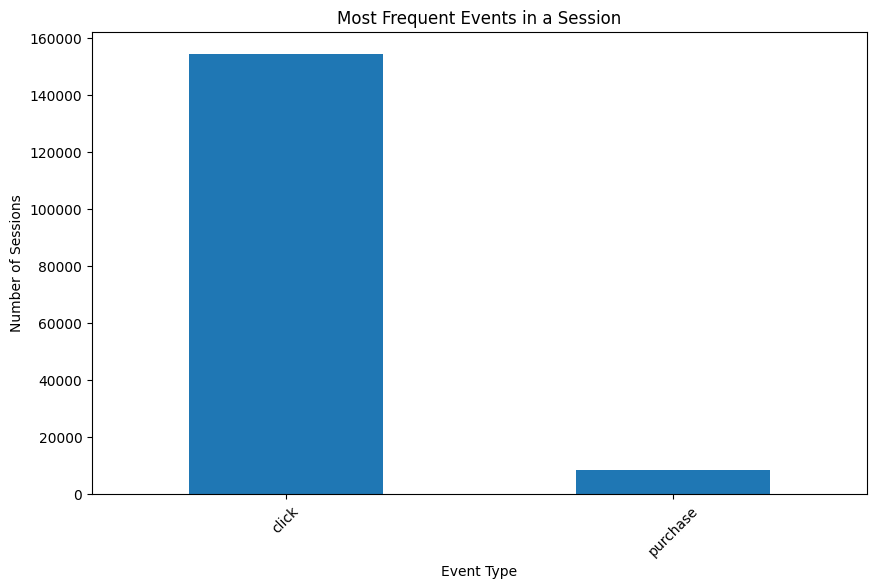

In [3]:
kullanici_df["timestamp"] = pd.to_datetime(kullanici_df["timestamp"], format="ISO8601")

session_event_counts = (
    kullanici_df.groupby("session_id")["event_type"].value_counts().unstack().fillna(0)
)

most_frequent_events_per_session = session_event_counts.idxmax(axis=1)

most_frequent_events_overall = most_frequent_events_per_session.value_counts()

plt.figure(figsize=(10, 6))
most_frequent_events_overall.plot(kind="bar")
plt.title("Most Frequent Events in a Session")
plt.xlabel("Event Type")
plt.ylabel("Number of Sessions")
plt.xticks(rotation=45)
plt.show()

In [4]:
# Click sonrası purchase eventine gitmedeki ortalama süre


click_events = kullanici_df[kullanici_df["event_type"] == "click"]
purchase_events = kullanici_df[kullanici_df["event_type"] == "purchase"]

merged_events = pd.merge(
    click_events, purchase_events, on="session_id", suffixes=("_click", "_purchase")
)

merged_events["time_diff"] = (
    merged_events["timestamp_purchase"] - merged_events["timestamp_click"]
)

average_transition_time = merged_events["time_diff"].mean()
print(f"Average transition time between click and purchase: {average_transition_time}")

Average transition time between click and purchase: 0 days 00:01:13.394102020


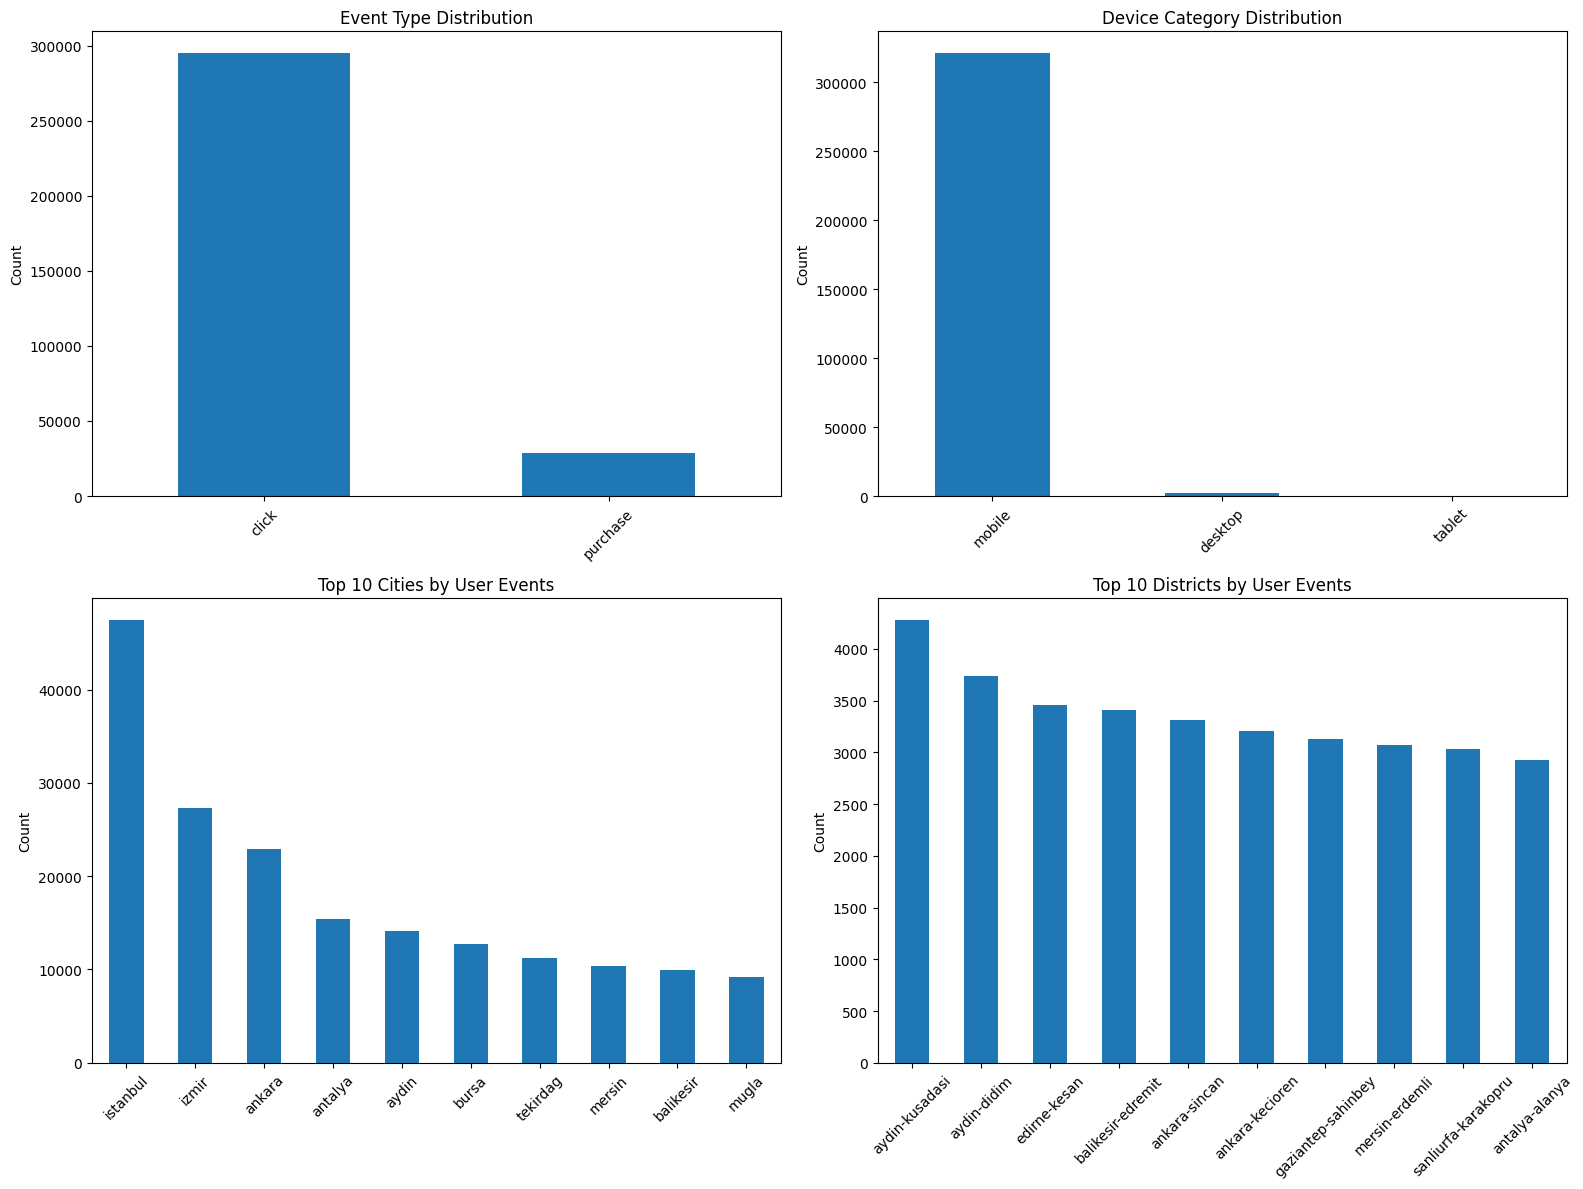

In [5]:
# Event Type, Device Category, City, ve District dağılımları

event_type_dist = kullanici_df["event_type"].value_counts()

device_category_dist = kullanici_df["device_category"].value_counts()

city_dist = kullanici_df["il"].value_counts().head(10)

district_dist = kullanici_df["ilce"].value_counts().head(10)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

event_type_dist.plot(kind="bar", ax=axes[0, 0], title="Event Type Distribution")
device_category_dist.plot(
    kind="bar", ax=axes[0, 1], title="Device Category Distribution"
)
city_dist.plot(kind="bar", ax=axes[1, 0], title="Top 10 Cities by User Events")
district_dist.plot(kind="bar", ax=axes[1, 1], title="Top 10 Districts by User Events")

for ax in axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

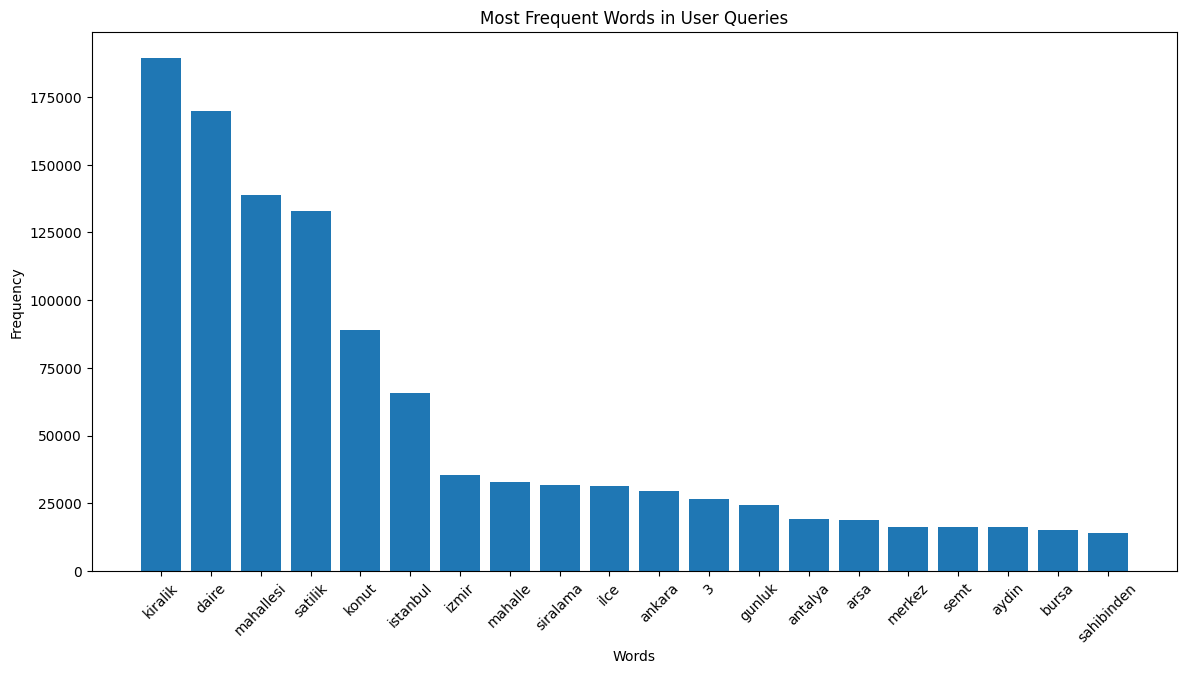

In [6]:
# user querylerindeki en çok kullanılan kelimeler
from collections import Counter
import re

all_queries = " ".join(kullanici_df["query"].dropna())
words = re.findall(r"\w+", all_queries.lower())

word_counts = Counter(words).most_common(20)

words, counts = zip(*word_counts)

plt.figure(figsize=(14, 7))
plt.bar(words, counts)
plt.title("Most Frequent Words in User Queries")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

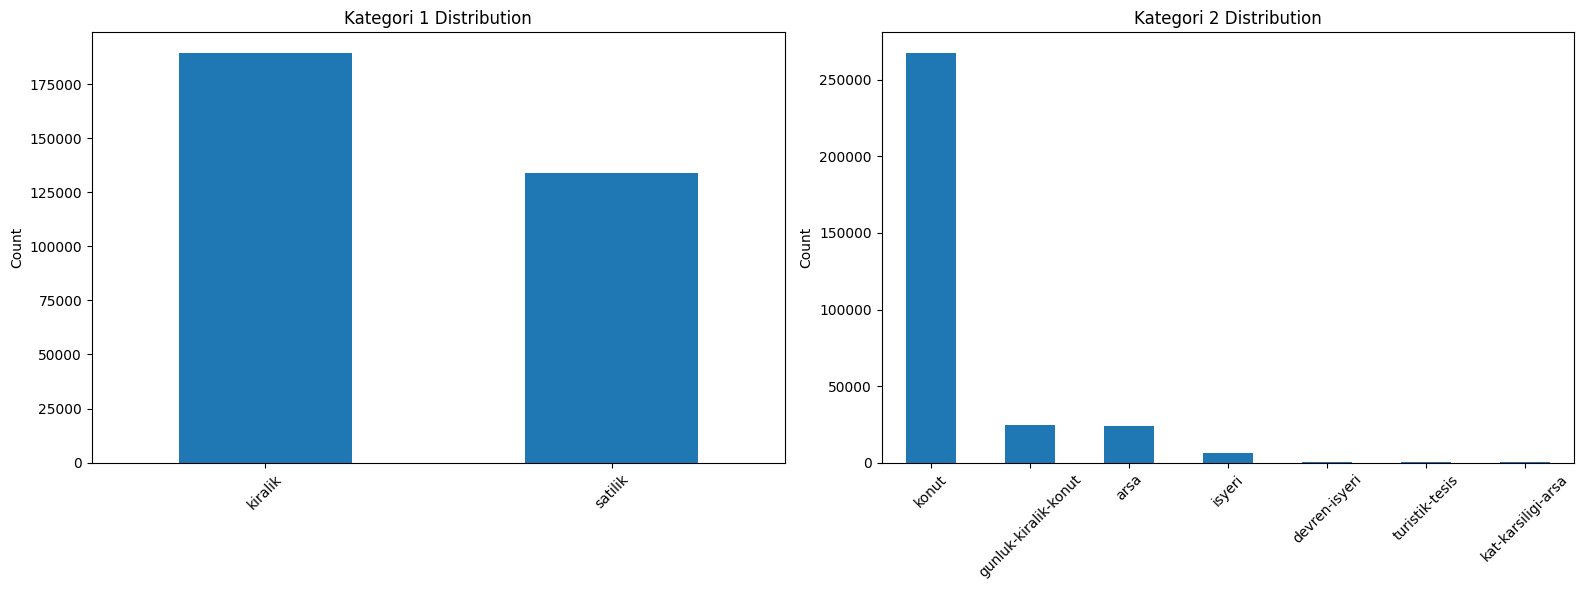

In [7]:
# kategori 1,2 dağılımları
kategori_1_dist = kullanici_df["kategori_1"].value_counts()

kategori_2_dist = kullanici_df["kategori_2"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

kategori_1_dist.plot(kind="bar", ax=axes[0], title="Kategori 1 Distribution")
kategori_2_dist.plot(kind="bar", ax=axes[1], title="Kategori 2 Distribution")

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

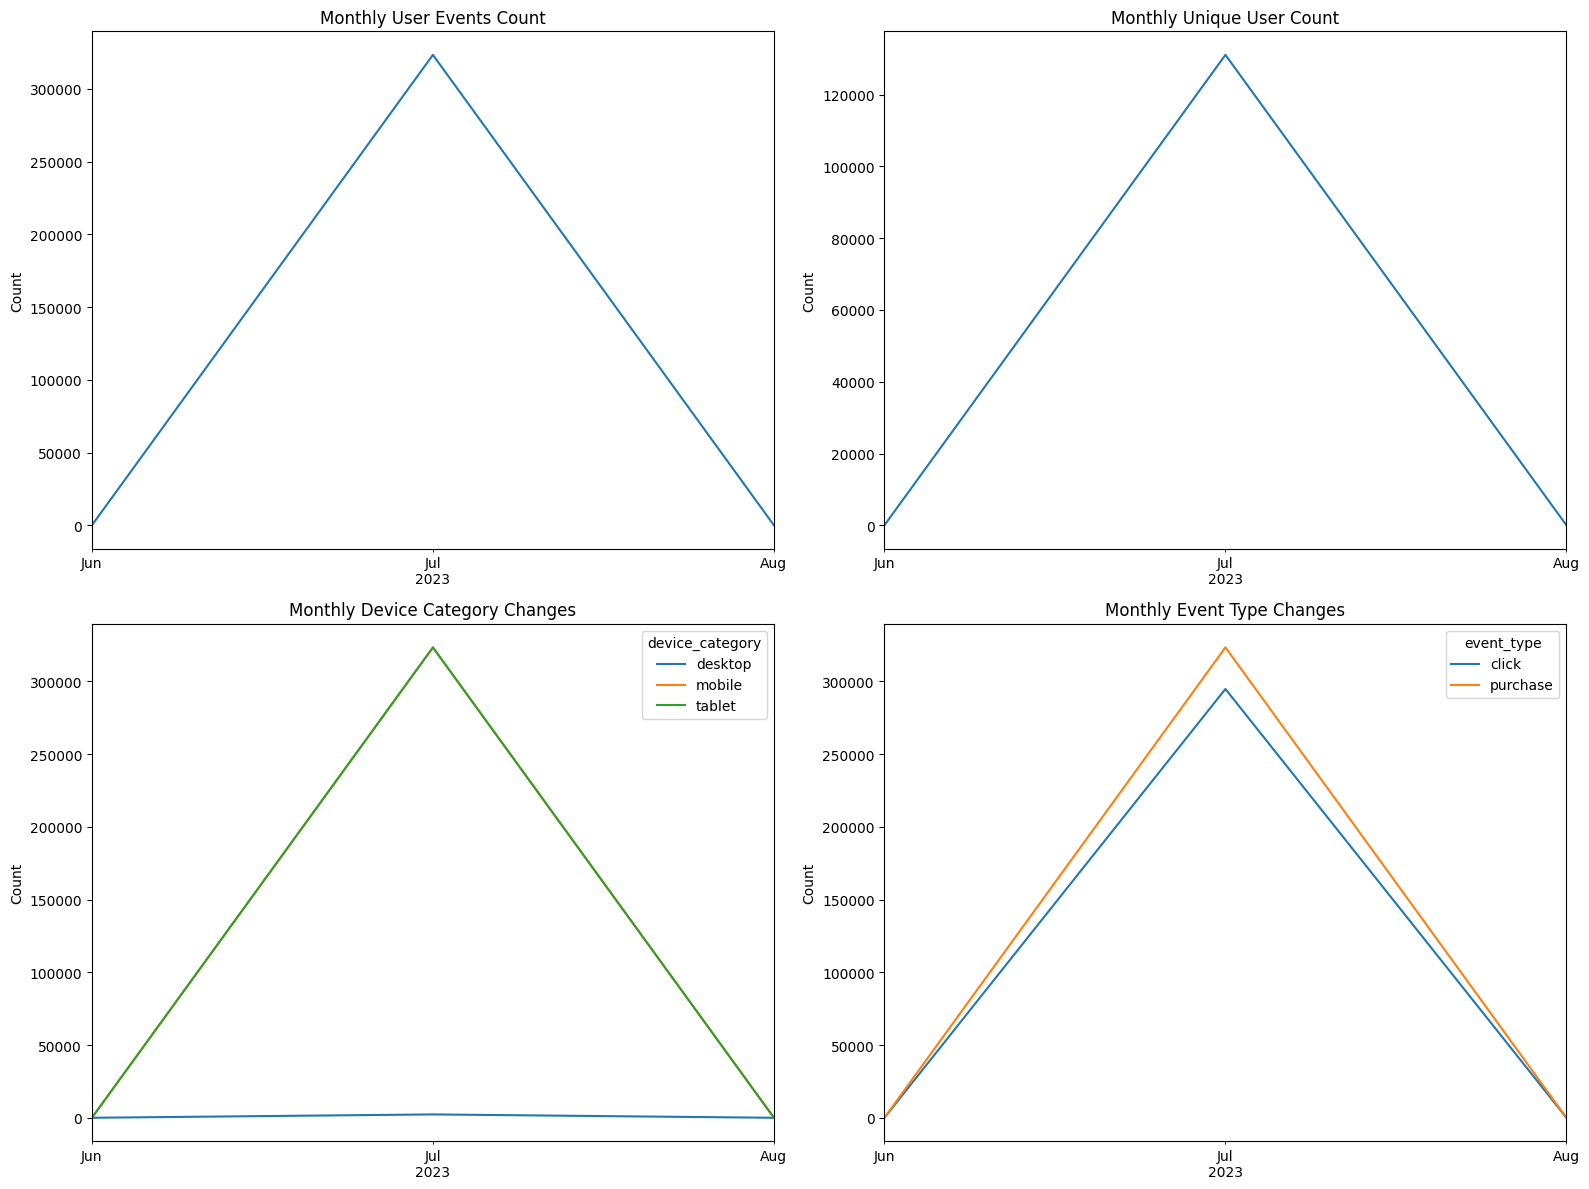

In [8]:
# aylık kırılımda event tipleri dağılımları
kullanici_df["year_month"] = kullanici_df["timestamp"].dt.to_period("M")

monthly_events_count = kullanici_df.groupby("year_month")["event_type"].count()

monthly_unique_users = kullanici_df.groupby("year_month")["client_id"].nunique()

monthly_device_category = (
    kullanici_df.groupby(["year_month", "device_category"])["event_type"]
    .count()
    .unstack()
    .fillna(0)
)
monthly_event_type = (
    kullanici_df.groupby(["year_month", "event_type"])["event_type"]
    .count()
    .unstack()
    .fillna(0)
)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

monthly_events_count.plot(kind="line", ax=axes[0, 0], title="Monthly User Events Count")
monthly_unique_users.plot(kind="line", ax=axes[0, 1], title="Monthly Unique User Count")
monthly_device_category.plot(
    kind="line", ax=axes[1, 0], title="Monthly Device Category Changes", stacked=True
)
monthly_event_type.plot(
    kind="line", ax=axes[1, 1], title="Monthly Event Type Changes", stacked=True
)

for ax in axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

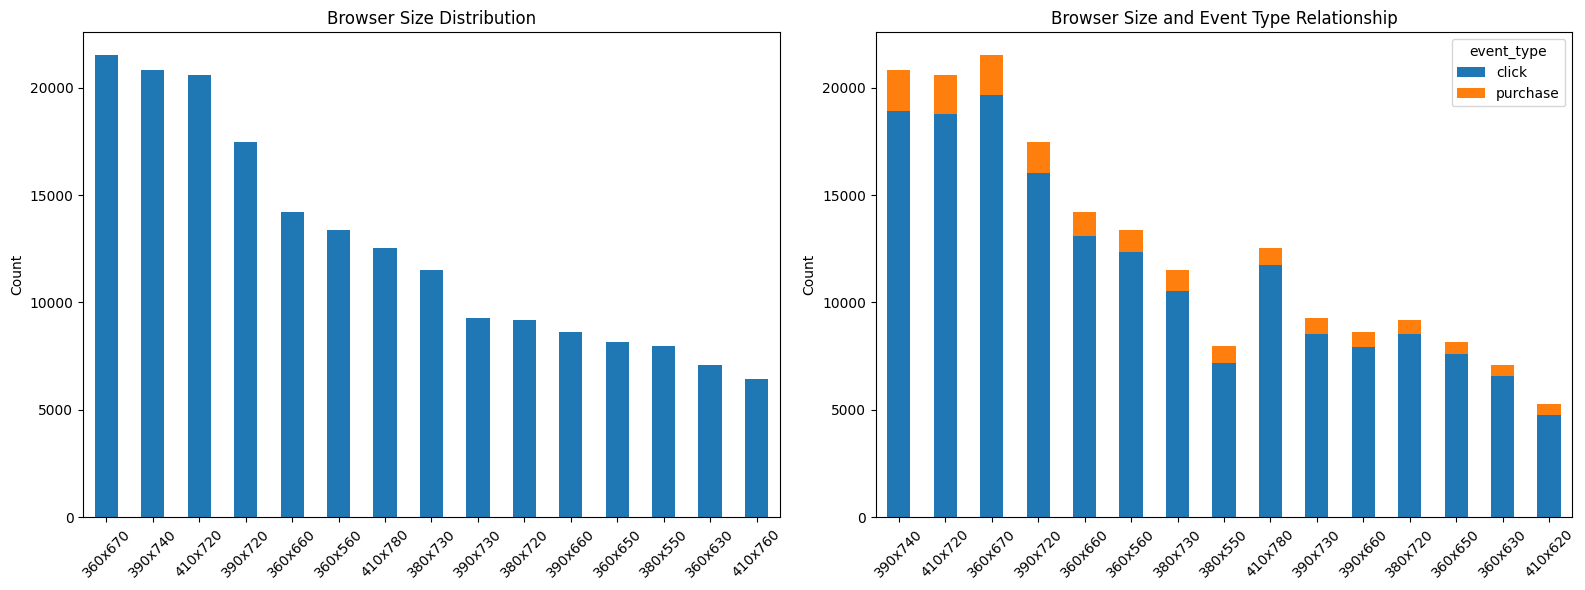

In [9]:
# browser size x event_type
browser_size_dist = kullanici_df["browser_size"].value_counts().head(15)

browser_size_event_type = (
    kullanici_df.groupby(["browser_size", "event_type"])["event_type"]
    .count()
    .unstack()
    .fillna(0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

browser_size_dist.plot(kind="bar", ax=axes[0], title="Browser Size Distribution")
browser_size_event_type.sort_values(by="purchase", ascending=False).head(15).plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    title="Browser Size and Event Type Relationship",
)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

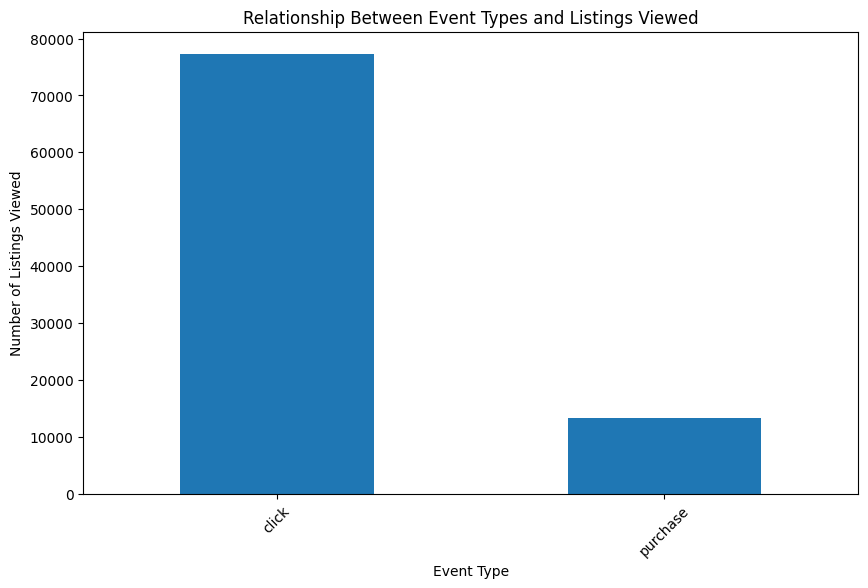

Average number of listings viewed by users: 2.2652449488593462


In [10]:
# ortalama olarak bir user kaç ilan görüntülüyor
listings_viewed_per_user = kullanici_df.groupby("client_id")["product_id"].nunique()

average_listings_viewed = listings_viewed_per_user.mean()

event_type_listing_views = kullanici_df.groupby("event_type")["product_id"].nunique()

plt.figure(figsize=(10, 6))
event_type_listing_views.plot(kind="bar")
plt.title("Relationship Between Event Types and Listings Viewed")
plt.xlabel("Event Type")
plt.ylabel("Number of Listings Viewed")
plt.xticks(rotation=45)
plt.show()

print(f"Average number of listings viewed by users: {average_listings_viewed}")

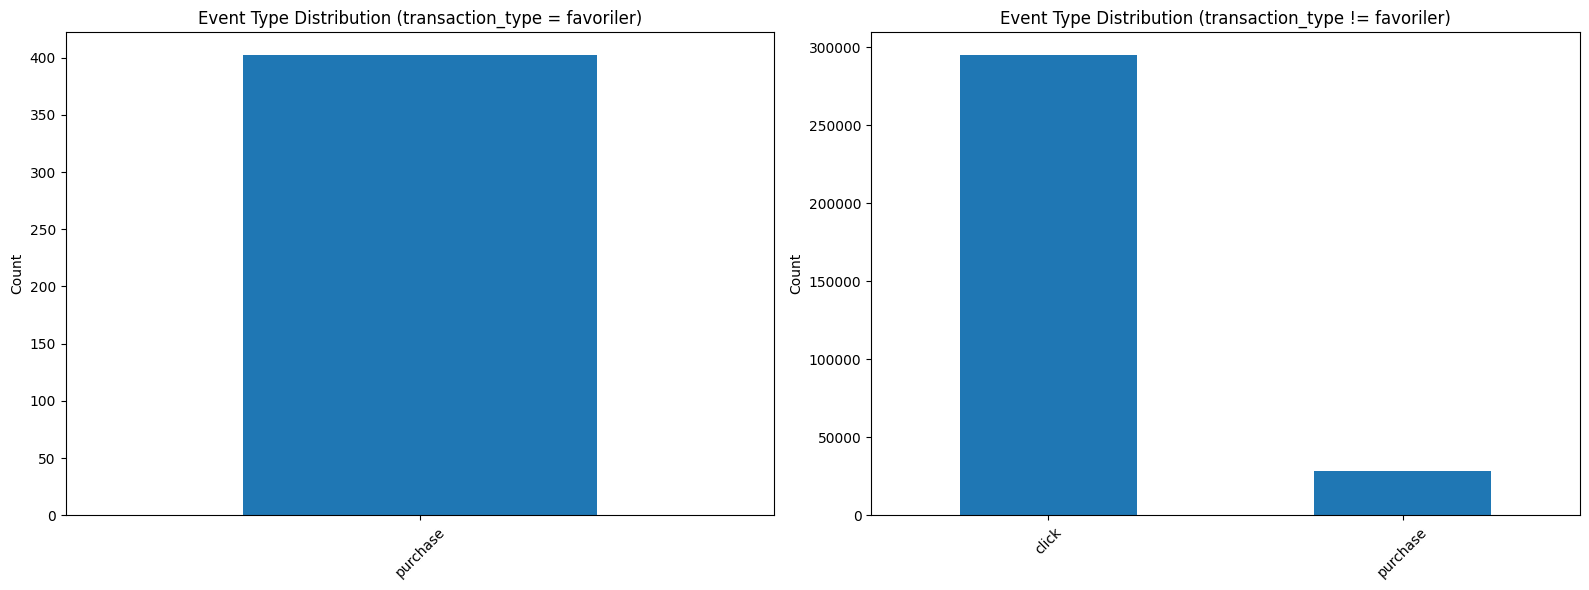

In [11]:
# transaction tipi favoriler olduğunda ve olmadığında event tipi dağılımı

favoriler_event_type_dist = kullanici_df[
    kullanici_df["transaction_type"] == "favoriler"
]["event_type"].value_counts()

not_favoriler_event_type_dist = kullanici_df[
    kullanici_df["transaction_type"] != "favoriler"
]["event_type"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

favoriler_event_type_dist.plot(
    kind="bar",
    ax=axes[0],
    title="Event Type Distribution (transaction_type = favoriler)",
)
not_favoriler_event_type_dist.plot(
    kind="bar",
    ax=axes[1],
    title="Event Type Distribution (transaction_type != favoriler)",
)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

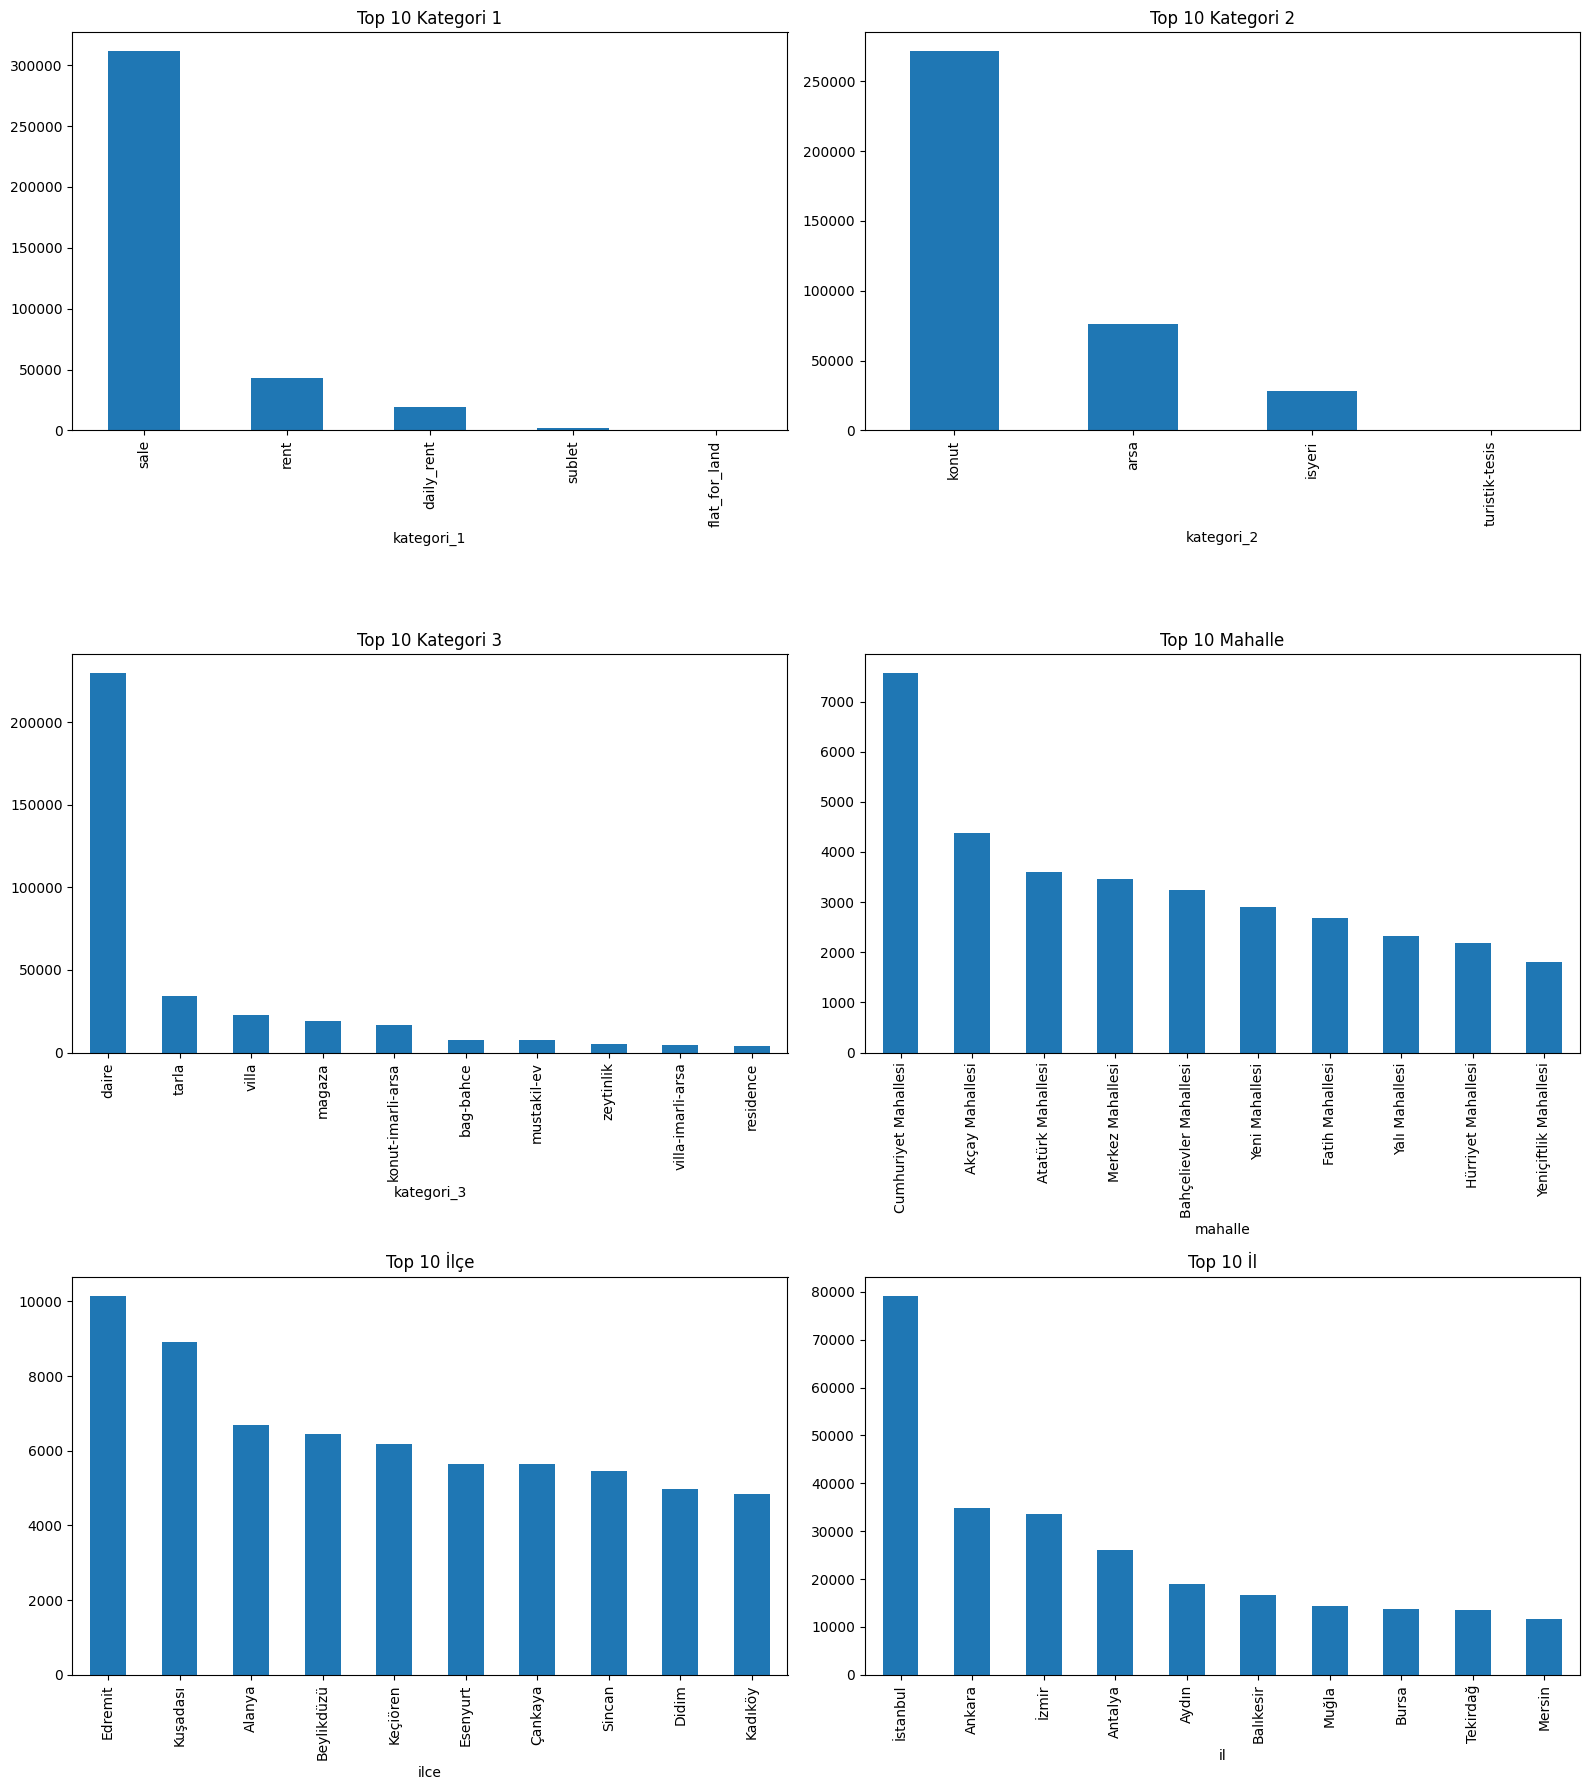

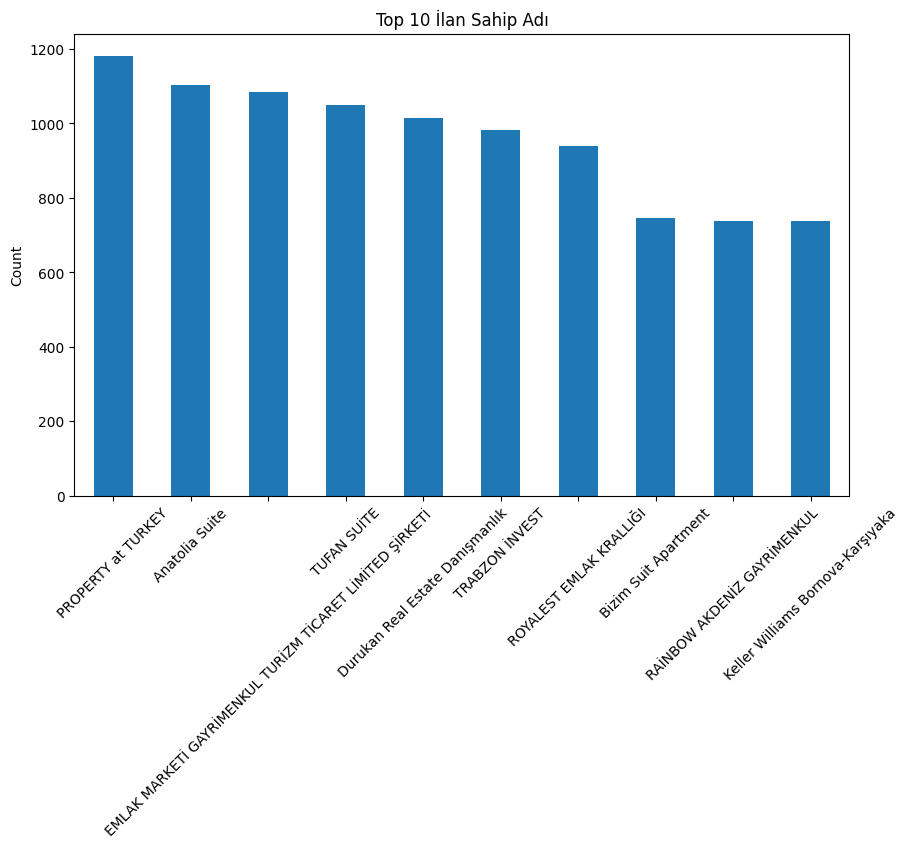

In [12]:
# top 10 dağılım for kategori 1,2,3
kategori_1_dist = ilan_df["kategori_1"].value_counts().head(10)
kategori_2_dist = ilan_df["kategori_2"].value_counts().head(10)
kategori_3_dist = ilan_df["kategori_3"].value_counts().head(10)
mahalle_dist = ilan_df["mahalle"].value_counts().head(10)
ilce_dist = ilan_df["ilce"].value_counts().head(10)
il_dist = ilan_df["il"].value_counts().head(10)
ilan_sahip_adi_dist = ilan_df["ilan_sahip_adi"].value_counts().head(10)

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

kategori_1_dist.plot(kind="bar", ax=axes[0, 0], title="Top 10 Kategori 1")
kategori_2_dist.plot(kind="bar", ax=axes[0, 1], title="Top 10 Kategori 2")
kategori_3_dist.plot(kind="bar", ax=axes[1, 0], title="Top 10 Kategori 3")
mahalle_dist.plot(kind="bar", ax=axes[1, 1], title="Top 10 Mahalle")
ilce_dist.plot(kind="bar", ax=axes[2, 0], title="Top 10 İlçe")
il_dist.plot(kind="bar", ax=axes[2, 1], title="Top 10 İl")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
ilan_sahip_adi_dist.plot(kind="bar")
plt.title("Top 10 İlan Sahip Adı")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

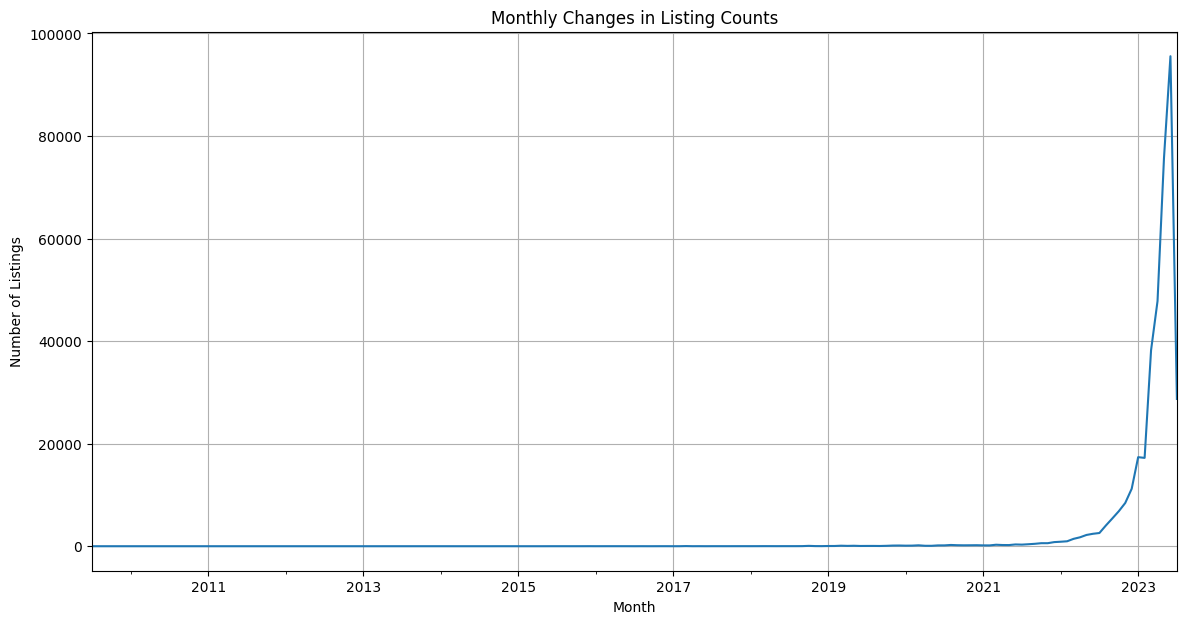

In [13]:
# aylık ilan sayısı değişimleri

ilan_df["created_at"] = pd.to_datetime(ilan_df["created_at"], format="mixed")

ilan_df["year_month"] = ilan_df["created_at"].dt.to_period("M")

monthly_listing_counts = ilan_df.groupby("year_month")["id"].count()

plt.figure(figsize=(14, 7))
monthly_listing_counts.plot(kind="line")
plt.title("Monthly Changes in Listing Counts")
plt.xlabel("Month")
plt.ylabel("Number of Listings")
plt.grid(True)
plt.show()

In [14]:
# ortalama, en uzun ve en kısa ilan update zamanları
ilan_df["updated_at"] = pd.to_datetime(ilan_df["updated_at"], format="mixed")

ilan_df["update_time"] = ilan_df["updated_at"] - ilan_df["created_at"]

average_update_time = ilan_df["update_time"].mean()

shortest_update_time_listing = ilan_df.loc[ilan_df["update_time"].idxmin()]
longest_update_time_listing = ilan_df.loc[ilan_df["update_time"].idxmax()]

print(f"Average update time: {average_update_time}")
print("Shortest update time listing:")
print(shortest_update_time_listing)
print("Longest update time listing:")
print(longest_update_time_listing)

Average update time: 83 days 13:58:58.358905143
Shortest update time listing:
id                                                       13528293
category_id                                                     1
kategori_1                                                   sale
kategori_2                                                   arsa
kategori_3                                      konut-imarli-arsa
mahalle                                     Selvilitepe Mahallesi
ilce                                                     Turgutlu
il                                                         Manisa
created_at                       2023-07-08 10:48:28.072000+00:00
updated_at                       2023-07-08 10:48:28.966388+00:00
ilan_baslik         Turgutlu Selvilitepe 4 Kat İmarlı Mevki Yerde
ilan_fiyat                                              2750000.0
ilan_sahip_adi                          NOVA GAYRİMENKUL TURGUTLU
site_icinde_mi                                              Fals

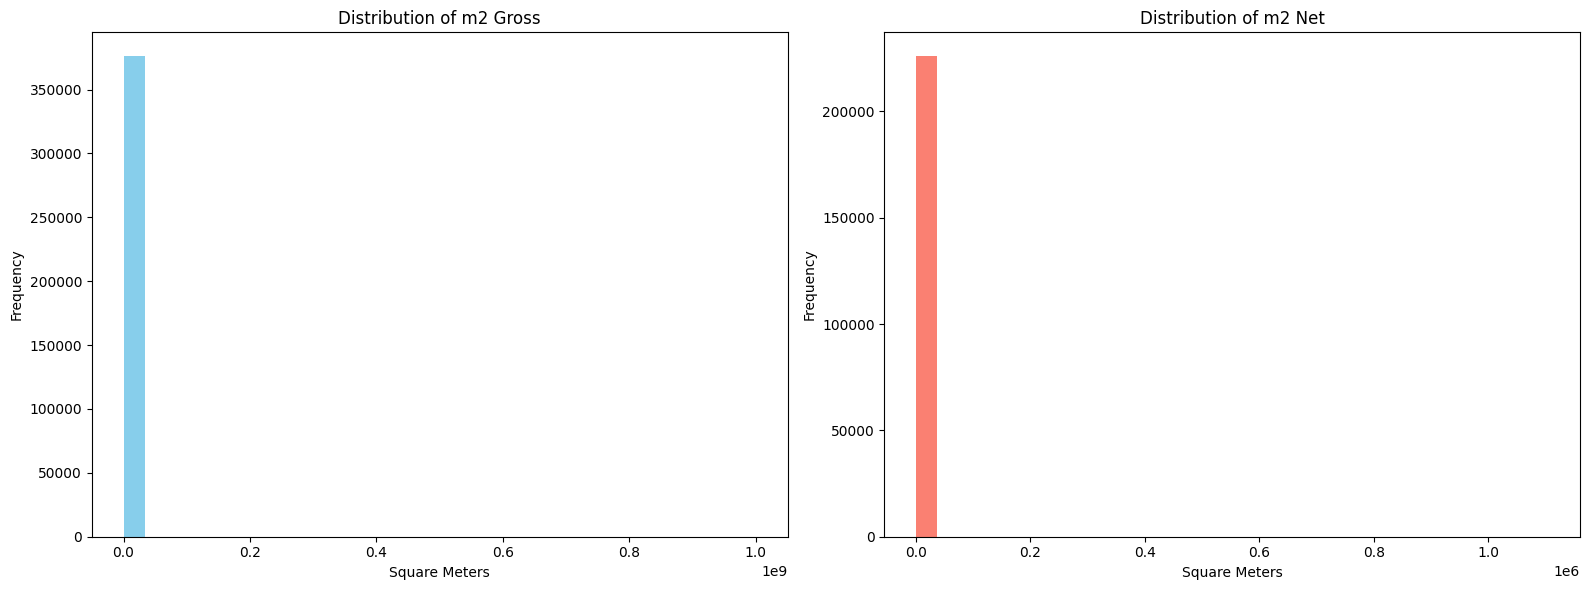

In [15]:
# m2, m2_gross dağılımları
m2_gross_dist = ilan_df["m2_gross"].dropna()
m2_net_dist = ilan_df["m2_net"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

m2_gross_dist.plot(
    kind="hist", bins=30, ax=axes[0], title="Distribution of m2 Gross", color="skyblue"
)
m2_net_dist.plot(
    kind="hist", bins=30, ax=axes[1], title="Distribution of m2 Net", color="salmon"
)

for ax in axes:
    ax.set_xlabel("Square Meters")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [16]:
ilan_fiyat_dist = ilan_df["ilan_fiyat"].dropna()
print(ilan_fiyat_dist.describe())

count    3.760700e+05
mean     5.723977e+06
std      9.436239e+07
min      2.000000e+01
25%      8.100000e+05
50%      1.890000e+06
75%      3.500000e+06
max      1.000000e+10
Name: ilan_fiyat, dtype: float64


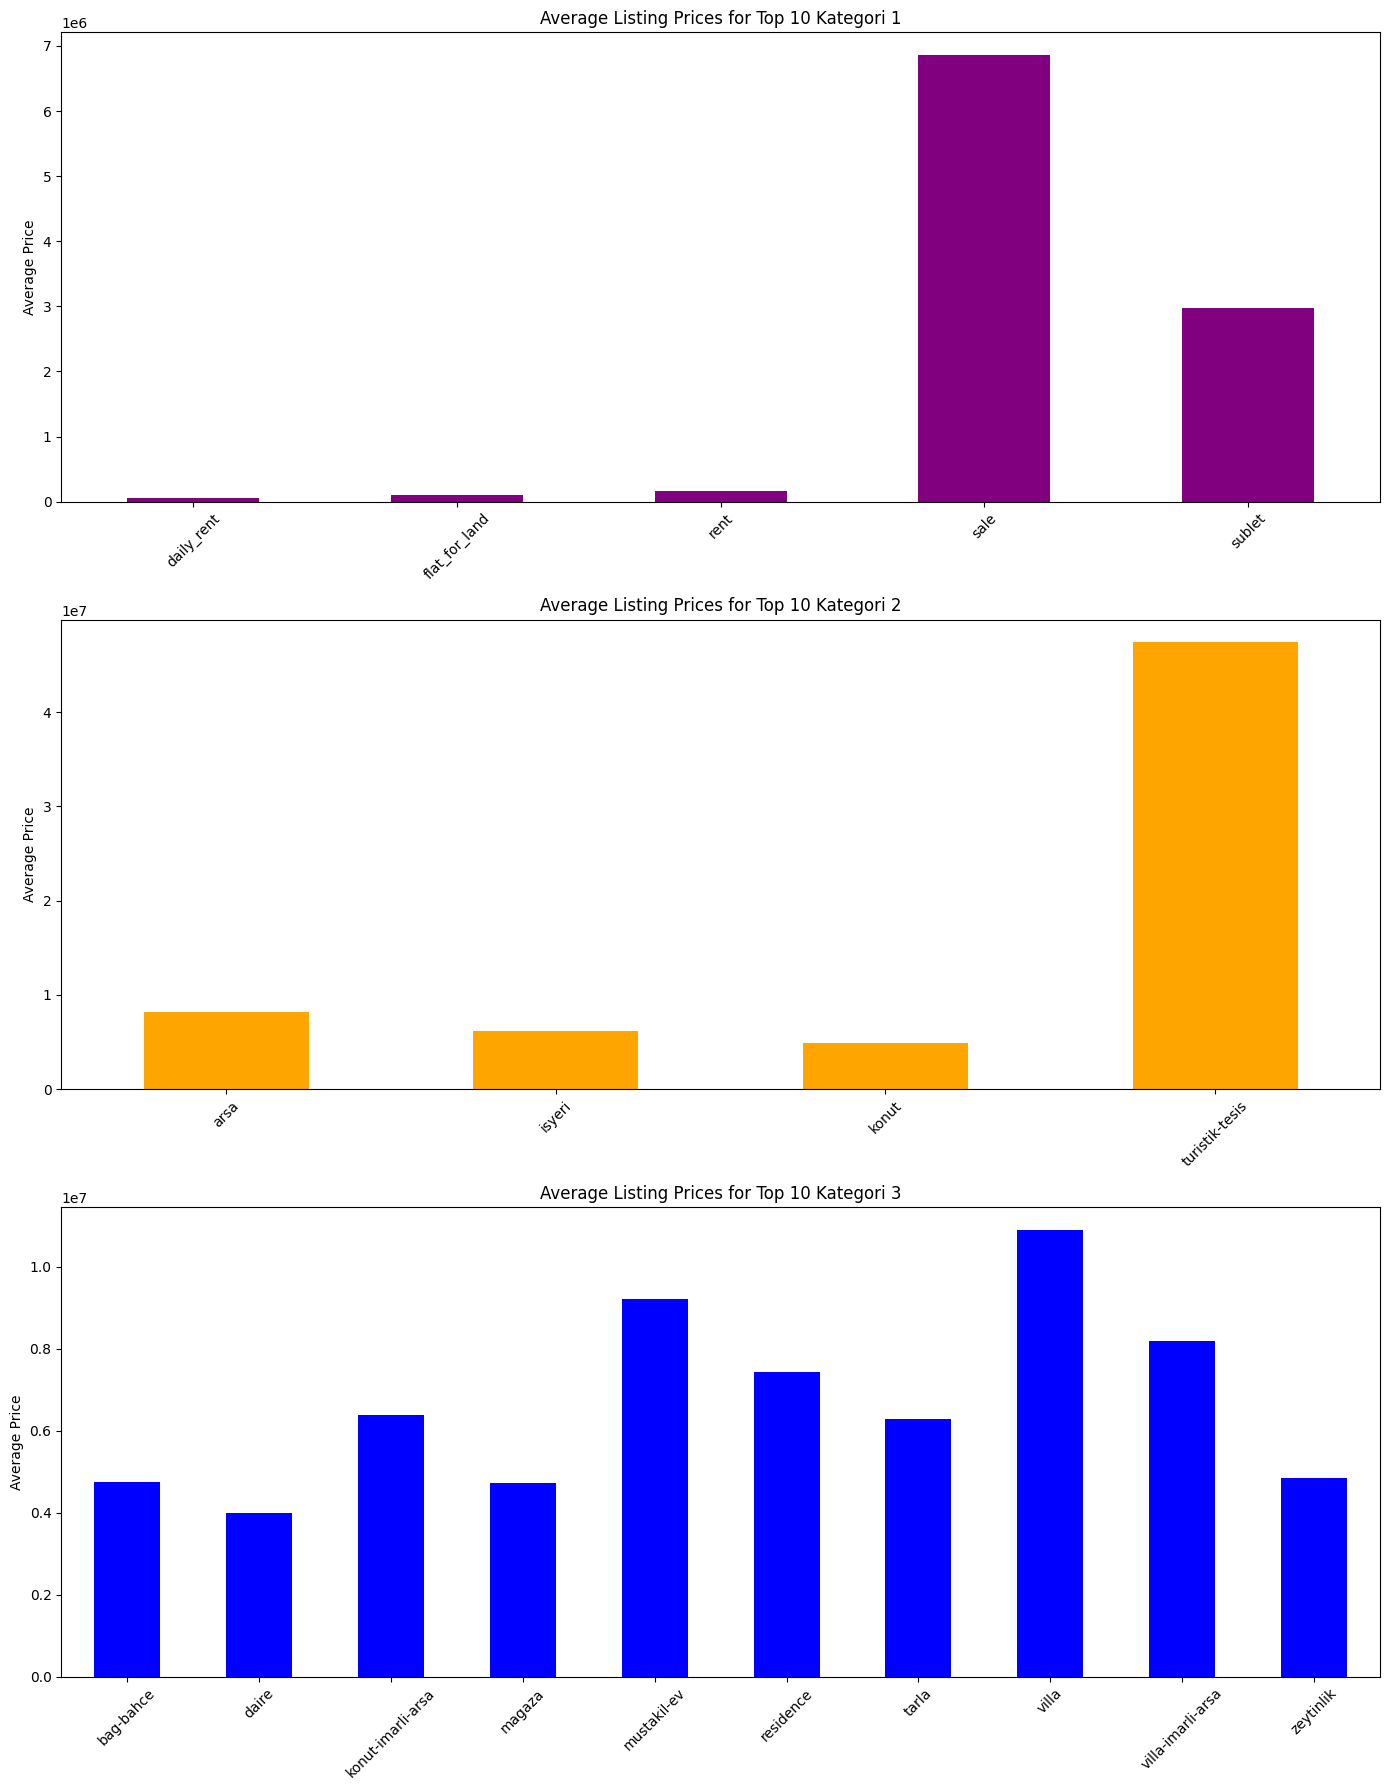

In [17]:
# Kategori kırılımlı ortalama ilan fiyatları
top_kategori_1 = ilan_df["kategori_1"].value_counts().head(10).index
top_kategori_2 = ilan_df["kategori_2"].value_counts().head(10).index
top_kategori_3 = ilan_df["kategori_3"].value_counts().head(10).index

avg_price_kategori_1 = (
    ilan_df[ilan_df["kategori_1"].isin(top_kategori_1)]
    .groupby("kategori_1")["ilan_fiyat"]
    .mean()
)
avg_price_kategori_2 = (
    ilan_df[ilan_df["kategori_2"].isin(top_kategori_2)]
    .groupby("kategori_2")["ilan_fiyat"]
    .mean()
)
avg_price_kategori_3 = (
    ilan_df[ilan_df["kategori_3"].isin(top_kategori_3)]
    .groupby("kategori_3")["ilan_fiyat"]
    .mean()
)

fig, axes = plt.subplots(3, 1, figsize=(14, 18))

avg_price_kategori_1.plot(
    kind="bar",
    ax=axes[0],
    title="Average Listing Prices for Top 10 Kategori 1",
    color="purple",
)
avg_price_kategori_2.plot(
    kind="bar",
    ax=axes[1],
    title="Average Listing Prices for Top 10 Kategori 2",
    color="orange",
)
avg_price_kategori_3.plot(
    kind="bar",
    ax=axes[2],
    title="Average Listing Prices for Top 10 Kategori 3",
    color="blue",
)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("Average Price")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

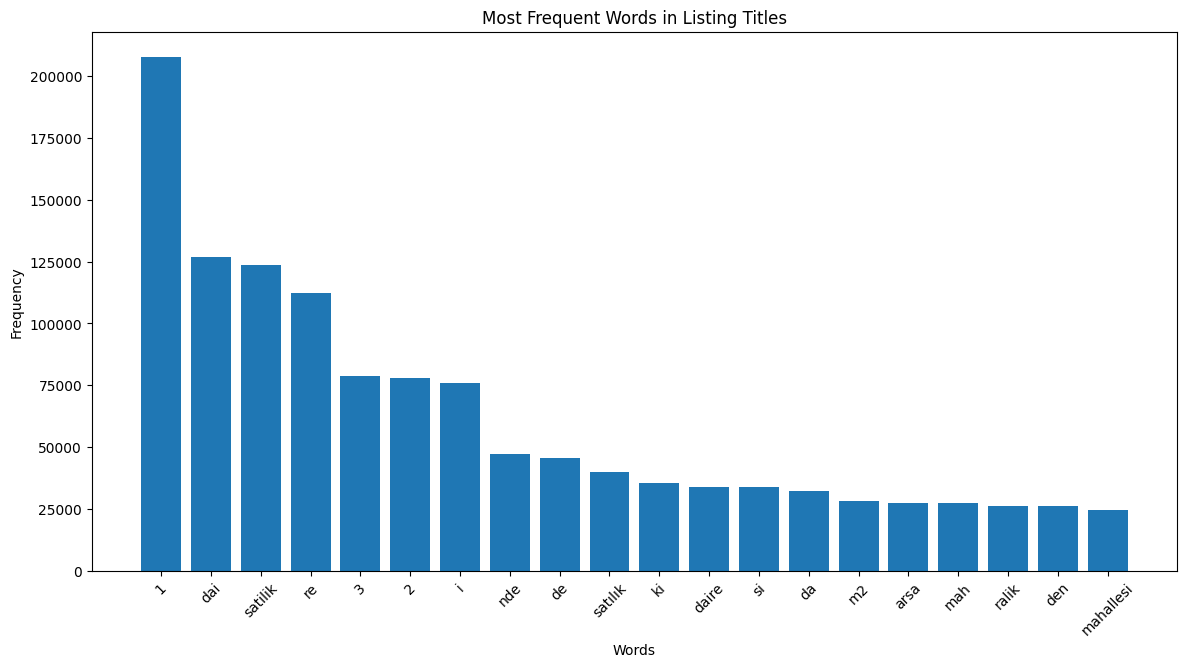

In [18]:
# En çok kullanılan ilan başlıkları
all_titles = " ".join(ilan_df["ilan_baslik"].dropna())
title_words = re.findall(r"\w+", all_titles.lower())

title_word_counts = Counter(title_words).most_common(20)

title_words, title_counts = zip(*title_word_counts)

plt.figure(figsize=(14, 7))
plt.bar(title_words, title_counts)
plt.title("Most Frequent Words in Listing Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

<Figure size 640x480 with 0 Axes>

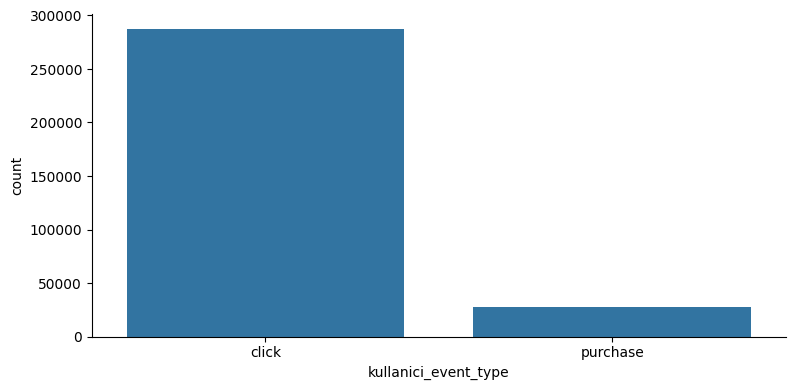

<Figure size 640x480 with 0 Axes>

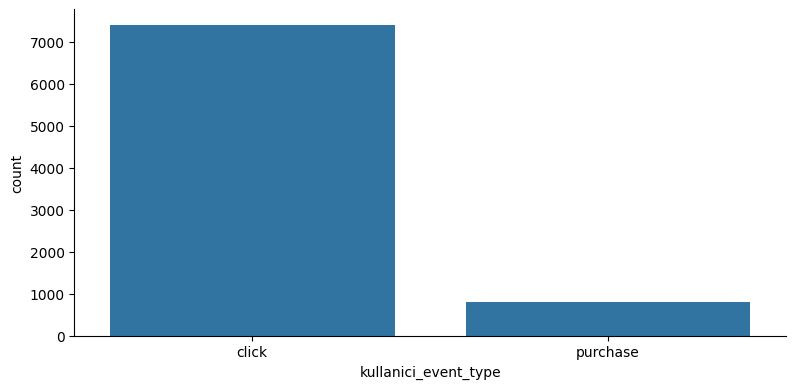

In [19]:
import unidecode

# Kullanıcı ve ilandaki il - ilçe farklı ve aynı olduğundaki event_type durumu
kullanici_df["product_id"] = kullanici_df["product_id"].astype(str)
ilan_df["id"] = ilan_df["id"].astype(str)
res = (
    kullanici_df.rename(columns={"product_id": "id"})
    .set_index("id")
    .add_prefix("kullanici_")
    .join(ilan_df.set_index("id").add_prefix("ilan_"))
)


res["kullanici_il"] = (
    res["kullanici_il"]
    .fillna("missing")
    .str.lower()
    .apply(lambda x: unidecode.unidecode(x))
)
res["ilan_il"] = (
    res["ilan_il"].fillna("missing").str.lower().apply(lambda x: unidecode.unidecode(x))
)

match = res.query("ilan_il==kullanici_il")
no_match = res.query("ilan_il!=kullanici_il")
plt.figure()
sns.catplot(data=match, kind="count", x="kullanici_event_type", height=4, aspect=2)
plt.figure()
sns.catplot(data=no_match, kind="count", x="kullanici_event_type", height=4, aspect=2)

<Figure size 640x480 with 0 Axes>

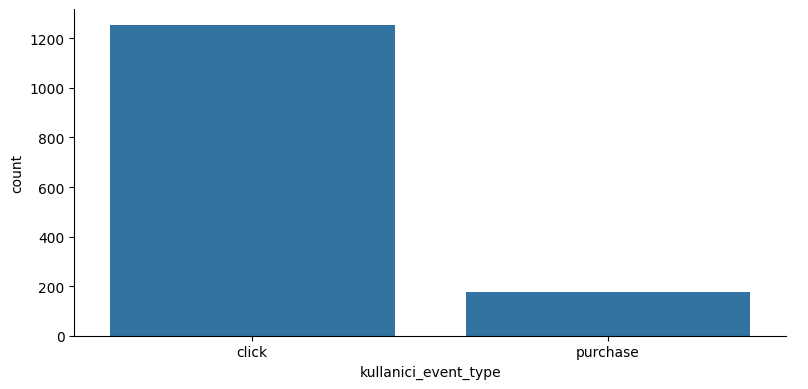

<Figure size 640x480 with 0 Axes>

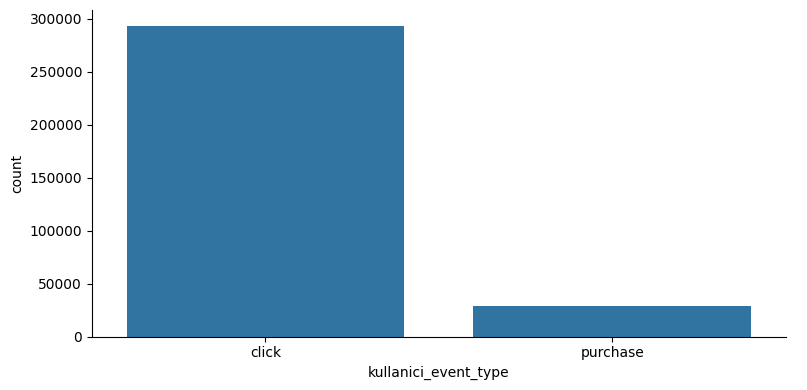

In [20]:
res["kullanici_ilce"] = (
    res["kullanici_ilce"]
    .fillna("missing")
    .str.lower()
    .apply(lambda x: unidecode.unidecode(x))
)
res["ilan_ilce"] = (
    res["ilan_ilce"]
    .fillna("missing")
    .str.lower()
    .apply(lambda x: unidecode.unidecode(x))
)

match = res.query("ilan_ilce==kullanici_ilce")
no_match = res.query("ilan_ilce!=kullanici_ilce")

plt.figure()
sns.catplot(data=match, kind="count", x="kullanici_event_type", height=4, aspect=2)
plt.figure()
sns.catplot(data=no_match, kind="count", x="kullanici_event_type", height=4, aspect=2)

# data sampling

In [21]:
#Bütün datayla çalışmak çok uzun sürdüğü için sample datayla çalıştım.
res = pd.read_csv("kullanıcı_davranışı_verisi.csv")
res = res[res["product_id"].isin(res["product_id"].values.tolist()[:2000])]
res.to_csv("kullanıcı_davranışı_verisi_sample.csv", index=False)
print("kullanici data sample shape: ", res.shape)

res = pd.read_csv("ilan_bilgileri.csv")
res = res[
    res["id"]
    .astype(str)
    .isin(
        pd.read_csv("kullanıcı_davranışı_verisi_sample.csv")["product_id"]
        .astype(str)
        .values.tolist()
    )
]
res.to_csv("ilan_bilgileri_sample.csv", index=False)
print("ilan data sample shape: ", res.shape)

kullanici data sample shape:  (38745, 24)
ilan data sample shape:  (1498, 26)


In [22]:
class DataLoader:
    """A class to load and preprocess data for user and advertisement datasets."""

    def __init__(self, user_file, ad_file):
        """
        Initializes the DataLoader class.

        Args:
            user_file (str): Path to the user data file.
            ad_file (str): Path to the advertisement data file.
        """
        self.user_file = user_file
        self.ad_file = ad_file

    def load_data(self):
        """Loads data from user and advertisement files."""
        self.user_data = pd.read_csv(self.user_file)
        self.ad_data = pd.read_csv(self.ad_file)

    def preprocess_data(self):
        """Preprocesses the loaded data."""
        self.user_data["product_id"] = self.user_data["product_id"].astype(str)
        self.ad_data["id"] = self.ad_data["id"].astype(str)
        self.ad_data = self.ad_data.add_prefix("ad_").reset_index()
        self.user_data = self.user_data.add_prefix("user_").reset_index()

        self.combined_data = self.user_data.merge(
            self.ad_data, left_on="user_product_id", right_on="ad_id", how="inner"
        )

    def get_data(self):
        """
        Returns the preprocessed combined data.

        Returns:
            pandas.DataFrame: The combined and preprocessed user and advertisement data.
        """
        return self.combined_data


data_loader = DataLoader(
    "kullanıcı_davranışı_verisi_sample.csv", "ilan_bilgileri_sample.csv"
)
data_loader.load_data()
data_loader.preprocess_data()
combined_data = data_loader.get_data()

# building graph

1. **Graph Yapısının Tanımlanması**: İlk adım olarak, bir heterojen graf oluşturulmuştur. Bu graf, kullanıcıların ilanlarla etkileşimlerini temsil etmek üzere çok çeşitli düğümler ve kenar türleri içerir.

2. **Düğümlerin Oluşturulması**:
    - Her kullanıcı, bir düğüm olarak temsil edilir. Kullanıcı düğümleri, "user_{user_client_id}" şeklinde adlandırılır.
    - Her ilan, bir düğüm olarak temsil edilir. İlan düğümleri, "ad_{ad_id}" şeklinde adlandırılır.
    - Her lokasyon (il, ilçe, mahalle), bir düğüm olarak temsil edilir. Lokasyon düğümleri, "loc_{location_name}" şeklinde adlandırılır.

3. **Kenarların Oluşturulması**:
    - **User-Ad Kenarları**: Bir kullanıcının bir ilanla etkileşimini temsil eder. Bu kenarlar, kullanıcı düğümleri ile ilan düğümleri arasında oluşturulur. Kenar türleri, etkileşim türlerine göre farklılık gösterir (örneğin, tıklama, favorilere ekleme).
    - **User-Location Kenarları**: Bir kullanıcının bir lokasyonla ilişkisini temsil eder. Bu kenarlar, kullanıcı düğümleri ile lokasyon düğümleri arasında oluşturulur.
    - **Ad-Location Kenarları**: Bir ilanın bir lokasyonla ilişkisini temsil eder. Bu kenarlar, ilan düğümleri ile lokasyon düğümleri arasında oluşturulur.
    - **Hierarchical Location Kenarları**: Lokasyonların hiyerarşik ilişkilerini temsil eder. Örneğin, bir ilçenin bir ille ilişkisi gibi. Bu kenarlar, lokasyon düğümleri arasında oluşturulur.

4. **Ağırlık Hesaplama**:
    - Her bir etkileşimin ağırlığı, çeşitli faktörlere dayanarak belirlenir. Örneğin, kullanıcının ilanı tıklaması, ilanın fiyatı, kullanıcının konumu gibi faktörlere bağlı olarak ağırlık atanır. Bu ağırlık, etkileşimin önemini yansıtır.


In [23]:
class GraphConstructor:
    """A class to construct and analyze a heterogeneous graph representing user-ad interactions."""

    def __init__(self, data):
        """
        Initializes the GraphConstructor class.

        Args:
            data (pandas.DataFrame): The input data containing user-ad interaction information.
        """
        self.data = data
        self.G = nx.MultiDiGraph()  # Heterogeneous graph with multiple edge types

    def build_graph(self):
        """Builds the graph using input data."""
        with ThreadPoolExecutor() as executor:
            executor.map(self.process_row, self.data.iterrows())

    def process_row(self, row_tuple):
        """
        Processes a row of data and adds nodes and edges to the graph.

        Args:
            row_tuple (tuple): A tuple containing the index and row data.
        """
        _, row = row_tuple
        user_node = f"user_{row['user_client_id']}"
        ad_node = f"ad_{row['ad_id']}"
        il_node = f"loc_{row['user_il']}"
        ilce_node = f"loc_{row['user_ilce']}"
        mahalle_node = f"loc_{row['user_mahalle']}"

        # User node
        self.G.add_node(user_node, type="user")

        # Ad node
        self.G.add_node(
            ad_node,
            type="ad",
            price=row["ad_ilan_fiyat"],
            category=row["ad_kategori_1"],
        )

        # Location nodes
        self.G.add_node(il_node, type="location", loc_type="il")
        self.G.add_node(ilce_node, type="location", loc_type="ilce")
        self.G.add_node(mahalle_node, type="location", loc_type="mahalle")

        # Hierarchical location edges
        self.G.add_edge(il_node, ilce_node, weight=1.0, type="location_hierarchy")
        self.G.add_edge(ilce_node, mahalle_node, weight=1.0, type="location_hierarchy")

        # User-Ad edge
        weight = self.calculate_weight(row)
        self.G.add_edge(
            user_node,
            ad_node,
            weight=weight,
            type=row["user_event_type"],
            timestamp=row["user_timestamp"],
            device=row["user_device_category"],
        )

        # User-Location edges
        self.G.add_edge(user_node, il_node, weight=1.0, type="user_location")
        self.G.add_edge(user_node, ilce_node, weight=1.0, type="user_location")
        self.G.add_edge(user_node, mahalle_node, weight=1.0, type="user_location")

        # Ad-Location edges
        self.G.add_edge(ad_node, il_node, weight=1.0, type="ad_location")
        self.G.add_edge(ad_node, ilce_node, weight=1.0, type="ad_location")
        self.G.add_edge(ad_node, mahalle_node, weight=1.0, type="ad_location")

    def calculate_weight(self, row):
        """
        Calculates the weight for a user-ad interaction based on various factors.

        Args:
            row (pandas.Series): A row of data containing user-ad interaction details.

        Returns:
            float: The weight assigned to the interaction.
        """
        weight = 1.0

        if row["user_il"] == row["ad_il"]:
            weight += 2.0

        if row["user_ilce"] == row["ad_ilce"]:
            weight += 1.5

        if row["user_mahalle"] == row["ad_mahalle"]:
            weight += 1.0

        if row["user_device_category"] == "mobile":
            weight += 1.0

        if row["user_event_type"] == "purchase":
            weight += 2.0

        if row["user_transaction_type"] == "favoriler":
            weight += 1.5

        # Time factor (more recent interactions get higher weight)
        current_time = datetime.now()
        interaction_time = pd.to_datetime(row["user_timestamp"])
        time_diff = (current_time - interaction_time).days
        if time_diff < 300:
            weight += 2.0
        elif time_diff < 900:
            weight += 1.0

        if row["user_kategori_1"] == row["ad_kategori_1"]:
            weight += 1.5
        if row["user_kategori_2"] == row["ad_kategori_2"]:
            weight += 1.0

        # Ad price (more expensive ads get higher weight)
        if row["ad_ilan_fiyat"] > 500000:
            weight += 1.0

        return weight

    def draw_graph(self, n_nodes=100):
        """
        Draws a subgraph of the constructed graph.

        Args:
            n_nodes (int): The number of nodes to include in the subgraph.
        """
        subgraph = self.G.subgraph(list(self.G.nodes)[:n_nodes])
        pos = nx.spring_layout(subgraph)
        plt.figure(figsize=(12, 8))

        node_colors = []
        for node in subgraph.nodes(data=True):
            if node[1]["type"] == "user":
                node_colors.append("blue")
            elif node[1]["type"] == "ad":
                node_colors.append("green")
            else:
                node_colors.append("red")

        edge_colors = []
        for u, v, data in subgraph.edges(data=True):
            if data["type"] == "click":
                edge_colors.append("cyan")
            elif data["type"] == "purchase":
                edge_colors.append("red")
            else:
                edge_colors.append("gray")

        edge_weights = [
            data.get("weight", 1.0) for u, v, data in subgraph.edges(data=True)
        ]  # Default value is 1.0
        nx.draw(
            subgraph,
            pos,
            node_color=node_colors,
            with_labels=True,
            edge_color=edge_colors,
            width=edge_weights,
            node_size=500,
            font_size=10,
        )

        plt.title("User-Ad Interaction Subgraph")
        plt.show()

    def detect_communities(self):
        """Detects communities in the graph using the greedy modularity maximization algorithm."""
        communities = nx.algorithms.community.greedy_modularity_communities(self.G)
        for i, community in enumerate(communities):
            print(f"Community {i + 1}: {list(community)}")

    def temporal_subgraphs(self):
        """Generates temporal subgraphs based on interaction time frames."""
        time_frames = [300, 600, 900]
        current_time = datetime.now()

        for days in time_frames:
            subgraph = nx.MultiDiGraph()
            for u, v, data in self.G.edges(data=True):
                if "timestamp" in data:
                    interaction_time = pd.to_datetime(data["timestamp"])
                    time_diff = (current_time - interaction_time).days
                    if time_diff <= days:
                        subgraph.add_edge(u, v, **data)

            print(f"Subgraph for interactions within the last {days} days:")
            self.draw_subgraph(subgraph, days)

    def draw_subgraph(self, subgraph, days):
        """
        Draws a subgraph of the constructed graph based on a specified time frame.

        Args:
            subgraph (networkx.Graph): The subgraph to draw.
            days (int): The time frame in days for which the subgraph represents interactions.
        """
        pos = nx.spring_layout(subgraph)
        plt.figure(figsize=(12, 8))

        node_colors = []
        for node in subgraph.nodes(data=True):
            if node[1]["type"] == "user":
                node_colors.append("blue")
            elif node[1]["type"] == "ad":
                node_colors.append("green")
            else:
                node_colors.append("red")

        edge_colors = []
        for u, v, data in subgraph.edges(data=True):
            if data["type"] == "click":
                edge_colors.append("cyan")
            elif data["type"] == "purchase":
                edge_colors.append("red")
            else:
                edge_colors.append("gray")

        edge_weights = [
            data.get("weight", 1.0) for u, v, data in subgraph.edges(data=True)
        ]  # Default value is 1.0
        nx.draw(
            subgraph,
            pos,
            node_color=node_colors,
            with_labels=True,
            edge_color=edge_colors,
            width=edge_weights,
            node_size=500,
            font_size=10,
        )

        plt.title(f"Subgraph for interactions within the last {days} days")
        plt.show()

    def get_graph(self):
        """
        Gets the constructed graph.

        Returns:
            networkx.Graph: The constructed heterogeneous graph.
        """
        return self.G


graph_constructor = GraphConstructor(combined_data)
graph_constructor.build_graph()

In [24]:
G = graph_constructor.get_graph()

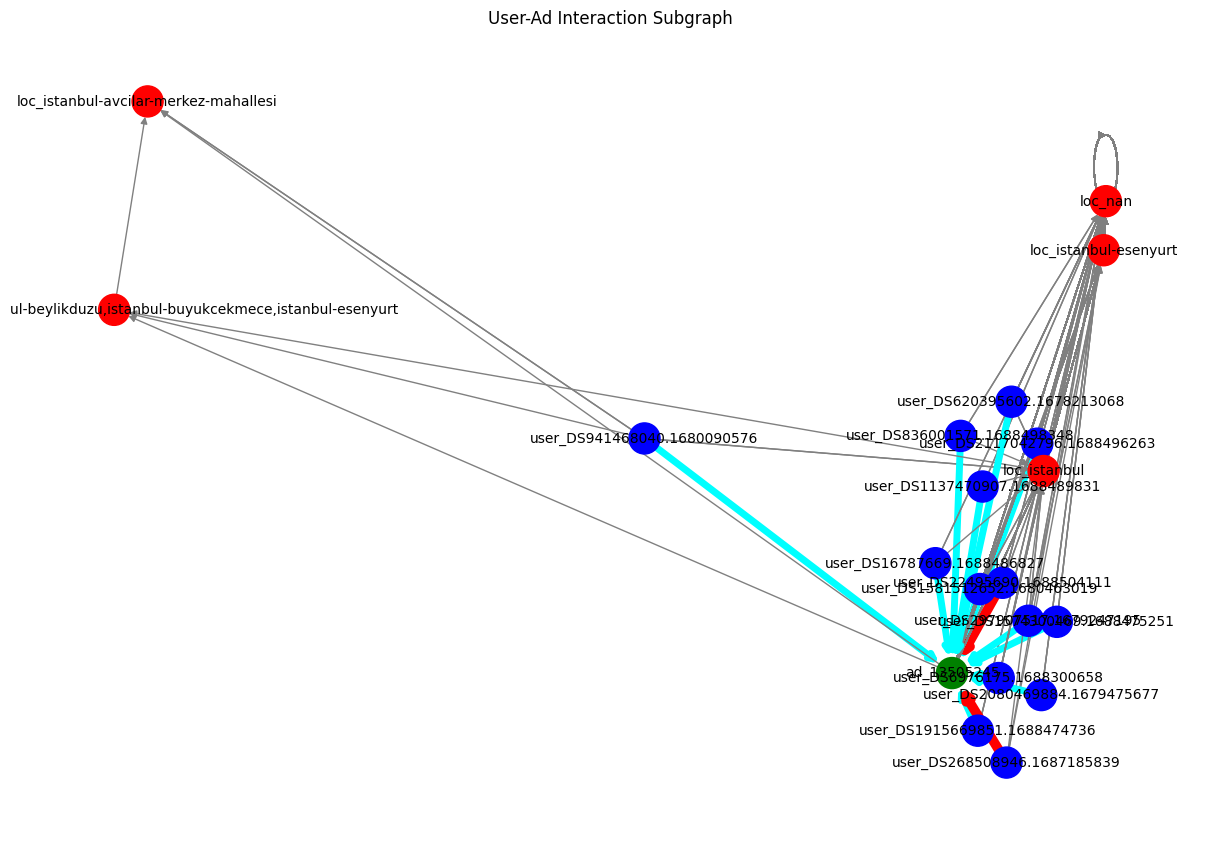

In [25]:
graph_constructor.draw_graph(n_nodes=20)

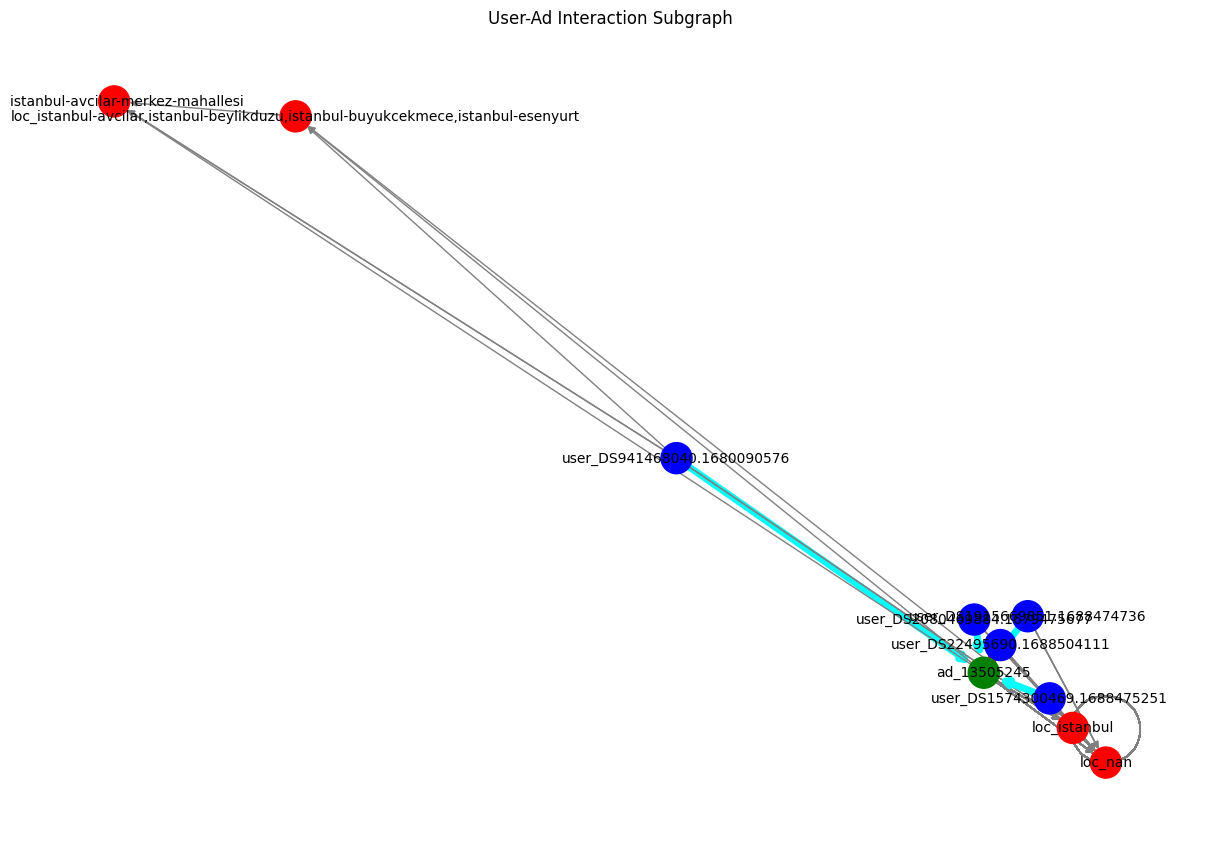

In [26]:
graph_constructor.draw_graph(n_nodes=10)

In [27]:
# Topluluk algılama
# graph_constructor.detect_communities()

# supervised embedding models

### Graph Convolutional Network (GCN) Model

**Kullanım Nedeni ve Mantığı**:
Graph Convolutional Network (GCN), grafik verilerinde düğümler arasındaki ilişkileri öğrenmek için tasarlanmış bir sinir ağı modelidir. Bu model, grafik evrişim işlemleri kullanarak düğüm özelliklerini günceller ve bu sayede düğümlerin komşuları arasındaki ilişkileri dikkate alır. Temel olarak, düğümlerin özelliklerini komşularının özellikleriyle birleştirerek daha zengin temsilciler elde etmeyi amaçlar.

**Avantajları**:
- Grafik verilerindeki lokal yapıların öğrenilmesinde etkilidir.
- Matematiksel olarak iyi tanımlanmış ve uygulanması nispeten basittir.
- Özellikle düğümler arasındaki kısa mesafeli ilişkileri iyi öğrenir.

**Dezavantajları**:
- Büyük grafiklerde hesaplama maliyeti artar ve bellek kullanımı yükselebilir.
- Uzun mesafeli düğümler arasındaki ilişkileri modellemek zor olabilir.

### Graph Attention Network (GAT) Model

**Kullanım Nedeni ve Mantığı**:
Graph Attention Network (GAT), grafik verilerinde dikkat mekanizması kullanarak düğümler arasındaki ilişkileri öğrenen bir modeldir. Bu model, her düğümün komşularının önemini öğrenir ve bu önem derecesine göre dikkat ağırlıkları atar. Bu sayede, her düğüm, komşularının kendisi için ne kadar önemli olduğunu öğrenir ve buna göre özelliklerini günceller.

**Avantajları**:
- Düğüm özelliklerinin daha hassas bir şekilde birleştirilmesini sağlar.
- Her düğümün farklı komşularına farklı ağırlıklar atayarak daha esnek bir model sunar.
- Özellikle heterojen grafiklerde (farklı türde düğümlerin ve kenarların olduğu grafikler) iyi performans gösterir.

**Dezavantajları**:
- Hesaplama açısından daha maliyetlidir ve daha fazla bellek gerektirir.
- Modelin eğitimi daha karmaşıktır ve daha uzun sürebilir.

### GraphSAGE Model

**Kullanım Nedeni ve Mantığı**:
GraphSAGE (Graph Sample and Aggregate), büyük ölçekli grafiklerde düğümlerden bilgi toplamak için örnekleme ve toplama (sample and aggregate) yöntemini kullanır. Bu model, her düğüm için belirli sayıda komşusunu rastgele seçer ve bu komşuların özelliklerini birleştirerek düğümün yeni özelliklerini hesaplar. Bu yöntem, özellikle büyük grafiklerde hesaplama maliyetlerini düşürmek için tasarlanmıştır.

**Avantajları**:
- Büyük ölçekli grafiklerde daha verimli ve hızlı çalışır.
- Hesaplama maliyetlerini düşürmek için örnekleme yöntemi kullanır.
- Özellikle bellek kısıtlamalarının olduğu durumlarda etkilidir.

**Dezavantajları**:
- Rastgele örnekleme nedeniyle bazı önemli bilgi kayıpları yaşanabilir.
- Komşu sayısı arttıkça modelin verimliliği düşebilir.

### Graph Isomorphism Network (GIN) Model

**Kullanım Nedeni ve Mantığı**:
Graph Isomorphism Network (GIN), grafik verilerinde isomorfizm (aynı yapıya sahip farklı grafikler) özelliklerini öğrenmek için tasarlanmış bir modeldir. Bu model, düğüm özelliklerini güncellerken komşularının özelliklerini güçlü bir şekilde birleştirir ve böylece grafik yapısını daha iyi öğrenir. GIN, özellikle grafik izomorfizmi testleri için optimize edilmiştir.

**Avantajları**:
- Grafik izomorfizmini güçlü bir şekilde öğrenir ve bu sayede farklı grafiklerin aynı yapıya sahip olup olmadığını belirlemede etkilidir.
- Düğüm özelliklerinin birleştirilmesinde yüksek performans gösterir.

**Dezavantajları**:
- Hesaplama maliyeti yüksek olabilir ve büyük grafiklerde verimliliği düşebilir.
- Özellikle grafik yapılarının çok farklı olduğu durumlarda zorlanabilir.


In [28]:
class BaseEmbeddingModel:
    """Base class for embedding models."""

    def __init__(self, data):
        """
        Initializes the BaseEmbeddingModel.

        Args:
            data: The input data for the model.
        """
        self.data = data

    def train(self, epochs):
        """
        Trains the embedding model.

        Args:
            epochs (int): The number of training epochs.

        Raises:
            NotImplementedError: If the method is not implemented by a subclass.
        """
        raise NotImplementedError("Each model must implement the train method.")

    def get_embeddings(self):
        """
        Retrieves the embeddings learned by the model.

        Returns:
            embeddings: The learned embeddings.

        Raises:
            NotImplementedError: If the method is not implemented by a subclass.
        """
        raise NotImplementedError(
            "Each model must implement the get_embeddings method."
        )

In [29]:
class SupervisedBaseEmbeddingModel(BaseEmbeddingModel):
    """
    Base class for supervised embedding models, derived from BaseEmbeddingModel.
    """

    def __init__(self, data, in_channels, hidden_channels, out_channels):
        """
        Initializes the SupervisedBaseEmbeddingModel.

        Args:
            data: The input data for the model.
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.
        """
        super().__init__(data)
        self.model = self.build_model(in_channels, hidden_channels, out_channels)
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=0.01, weight_decay=5e-4
        )
        self.criterion = nn.NLLLoss()

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the neural network model for the embedding.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed neural network model.

        Raises:
            NotImplementedError: If the method is not implemented by a subclass.
        """
        raise NotImplementedError("Each model must implement the build_model method.")

    def train(self, epochs=100):
        """
        Trains the embedding model.

        Args:
            epochs (int): The number of training epochs.

        Returns:
            self: The trained model instance.
        """
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            out = self.model(self.data)
            loss = self.criterion(
                out[self.data.train_mask], self.data.y[self.data.train_mask]
            )
            loss.backward()
            self.optimizer.step()
        return self

    def evaluate(self):
        """
        Evaluates the model's performance on the test data.

        Returns:
            float: The accuracy of the model on the test data.
        """
        self.model.eval()
        _, pred = self.model(self.data).max(dim=1)
        correct = (pred[self.data.test_mask] == self.data.y[self.data.test_mask]).sum()
        acc = int(correct) / int(self.data.test_mask.sum())
        return acc

    def get_embeddings(self):
        """
        Retrieves the embeddings learned by the model.

        Returns:
            numpy.ndarray: The learned embeddings.
        """
        self.model.eval()
        with torch.no_grad():
            out = self.model(self.data)
        return out.cpu().numpy()


class GCNModel(SupervisedBaseEmbeddingModel):
    """
    Graph Convolutional Network (GCN) Model.

    Inherits from SupervisedBaseEmbeddingModel.
    """

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the GCN model.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed GCN model.
        """
        return GCN(in_channels, hidden_channels, out_channels)


class GATModel(SupervisedBaseEmbeddingModel):
    """
    Graph Attention Network (GAT) Model.

    Inherits from SupervisedBaseEmbeddingModel.
    """

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the GAT model.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed GAT model.
        """
        return GAT(in_channels, hidden_channels, out_channels)


class GraphSAGEModel(SupervisedBaseEmbeddingModel):
    """
    GraphSAGE Model.

    Inherits from SupervisedBaseEmbeddingModel.
    """

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the GraphSAGE model.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed GraphSAGE model.
        """
        return GraphSAGE(in_channels, hidden_channels, out_channels)


class GINModel(SupervisedBaseEmbeddingModel):
    """
    Graph Isomorphism Network (GIN) Model.

    Inherits from SupervisedBaseEmbeddingModel.
    """

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the GIN model.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed GIN model.
        """
        return GIN(in_channels, hidden_channels, out_channels)


class GCN(nn.Module):
    """
    Graph Convolutional Network (GCN) model.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        out_channels (int): Number of output channels.
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Args:
            data (torch_geometric.data.Data): Input graph data object.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class GAT(nn.Module):
    """
    Graph Attention Network (GAT) model.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        out_channels (int): Number of output channels.
        heads (int, optional): Number of attention heads (default: 8).
    """

    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels, heads=1, concat=True, dropout=0.6
        )

    def forward(self, data):
        """
        Forward pass of the GAT model.

        Args:
            data (torch_geometric.data.Data): Input graph data object.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class GraphSAGE(nn.Module):
    """
    GraphSAGE model.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        out_channels (int): Number of output channels.
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        """
        Forward pass of the GraphSAGE model.

        Args:
            data (torch_geometric.data.Data): Input graph data object.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class GIN(nn.Module):
    """
    Graph Isomorphism Network (GIN) model.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        out_channels (int): Number of output channels.
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
            )
        )
        self.conv2 = GINConv(
            nn.Sequential(
                nn.Linear(hidden_channels, out_channels),
                nn.ReLU(),
                nn.Linear(out_channels, out_channels),
            )
        )

    def forward(self, data):
        """
        Forward pass of the GIN model.

        Args:
            data (torch_geometric.data.Data): Input graph data object.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# unsupservised embedding models

### Node2Vec Model

**Kullanım Nedeni ve Mantığı**:
Node2Vec, düğümler arasında rastgele yürüyüşler yaparak gömme vektörleri (embeddings) oluşturan denetimsiz bir modeldir. Bu model, düğümler arasındaki yapısal benzerlikleri ve ortak bağlantıları öğrenmek için rastgele yürüyüşlerden elde edilen bağlam bilgilerini kullanır. Node2Vec, her düğüm için belirli sayıda rastgele yürüyüş gerçekleştirir ve bu yürüyüşlerden elde edilen verilerle gömme vektörleri oluşturur.

**Avantajları**:
- **Esneklik**: Rastgele yürüyüşlerin uzunluğu ve sayısı gibi parametrelerle özelleştirilebilir, bu da farklı veri setleri ve uygulamalar için esneklik sağlar.
- **Verimlilik**: Büyük grafiklerde bile hızlı ve verimli bir şekilde çalışır.
- **Gömme Kalitesi**: Düğümler arasındaki benzerlikleri ve bağlantıları iyi bir şekilde yakalar, bu da yüksek kaliteli gömme vektörleri oluşturur.

**Dezavantajları**:
- **Parametre Ayarları**: Modelin performansı, rastgele yürüyüş uzunluğu, bağlam penceresi boyutu ve negatif örnek sayısı gibi parametrelere büyük ölçüde bağlıdır.
- **Hafıza Kullanımı**: Büyük grafiklerde rastgele yürüyüşlerin hafıza kullanımı yüksek olabilir.

### Graph Autoencoder (GAE) Model

**Kullanım Nedeni ve Mantığı**:
Graph Autoencoder (GAE), düğüm özelliklerini öğrenmek için grafik verilerini kodlayan ve kod çözen bir denetimsiz modeldir. GAE, grafik evrişimli katmanlar (GCN) kullanarak düğüm özelliklerini kodlar ve ardından bu kodlamaları yeniden oluşturur. Bu süreç, grafik yapısını ve düğümler arasındaki ilişkileri öğrenmek için kullanılır.

**Avantajları**:
- **Yapısal Bilgi**: Grafik yapısını ve düğümler arasındaki ilişkileri iyi bir şekilde yakalar, bu da daha anlamlı gömme vektörleri sağlar.
- **Özellik Öğrenimi**: Grafik verilerindeki özellikleri ve düğümler arasındaki ilişkileri öğrenmek için güçlü bir yöntemdir.
- **Yüksek Performans**: Düğüm özelliklerini yüksek doğrulukla yeniden oluşturabilir, bu da modelin genel performansını artırır.

**Dezavantajları**:
- **Hesaplama Maliyeti**: GAE, grafik evrişimli katmanlar kullandığından hesaplama maliyeti yüksek olabilir.
- **Hafıza Kullanımı**: Büyük grafiklerde yüksek bellek kullanımı gerektirebilir, bu da performans sorunlarına yol açabilir.

### GAE vs. Node2Vec

Her iki model de denetimsiz grafik gömme yöntemleri olarak kullanılır, ancak farklı yaklaşımlar ve avantajlarla gelirler:

- **Node2Vec**, rastgele yürüyüşler yaparak düğümler arasındaki ilişkileri öğrenir ve düğüm gömme vektörleri oluşturur. Bu, özellikle büyük grafiklerde hızlı ve verimli bir yöntemdir, ancak parametre ayarları hassas olabilir.
- **GAE**, grafik yapısını kodlama ve kod çözme süreciyle düğüm özelliklerini öğrenir. Bu, daha derin ve yapılandırılmış bilgi yakalamada etkilidir, ancak hesaplama ve hafıza maliyeti yüksektir.


In [30]:
class UnsupervisedBaseEmbeddingModel(BaseEmbeddingModel):
    """
    Base class for unsupervised embedding models, derived from BaseEmbeddingModel.
    """

    pass


class Node2VecModel(UnsupervisedBaseEmbeddingModel):
    """
    Node2Vec model for unsupervised node embeddings.

    Inherits from UnsupervisedBaseEmbeddingModel.
    """

    def __init__(
        self,
        data,
        embedding_dim=64,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=1,
    ):
        """
        Initializes the Node2VecModel.

        Args:
            data: The input data for the model.
            embedding_dim (int): Dimensionality of the node embeddings (default: 64).
            walk_length (int): Length of the random walks (default: 20).
            context_size (int): Size of the context window for generating skip-gram pairs (default: 10).
            walks_per_node (int): Number of random walks per node (default: 10).
            num_negative_samples (int): Number of negative samples for negative sampling (default: 1).
        """
        super().__init__(data)
        self.model = Node2Vec(
            data.edge_index,
            embedding_dim=embedding_dim,
            walk_length=walk_length,
            context_size=context_size,
            walks_per_node=walks_per_node,
            num_negative_samples=num_negative_samples,
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train(self, epochs=100):
        """
        Trains the Node2Vec model.

        Args:
            epochs (int): Number of training epochs (default: 100).

        Returns:
            self: The trained model instance.
        """
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.model.loss(self.data.pos_edge_index)
            loss.backward()
            self.optimizer.step()
        return self

    def get_embeddings(self):
        """
        Retrieves the embeddings learned by the Node2Vec model.

        Returns:
            numpy.ndarray: The learned embeddings.
        """
        self.model.eval()
        return self.model().detach().cpu().numpy()


class GAEModel(UnsupervisedBaseEmbeddingModel):
    """
    Graph Autoencoder (GAE) model for unsupervised node embeddings.

    Inherits from UnsupervisedBaseEmbeddingModel.
    """

    def __init__(self, data, in_channels, hidden_channels):
        """
        Initializes the GAEModel.

        Args:
            data: The input data for the model.
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
        """
        super().__init__(data)
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.model = GAE(self.encoder)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train(self, epochs=100):
        """
        Trains the GAE model.

        Args:
            epochs (int): Number of training epochs (default: 100).

        Returns:
            self: The trained model instance.
        """
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            z = self.model.encode(self.data.x, self.data.edge_index)
            loss = self.model.recon_loss(z, self.data.edge_index)
            loss.backward()
            self.optimizer.step()
        return self

    def get_embeddings(self):
        """
        Retrieves the embeddings learned by the GAE model.

        Returns:
            numpy.ndarray: The learned embeddings.
        """
        self.model.eval()
        with torch.no_grad():
            z = self.model.encode(self.data.x, self.data.edge_index)
        return z.cpu().numpy()

# Semi-supervised embedding models

In [31]:
class SemiSupervisedBaseEmbeddingModel(SupervisedBaseEmbeddingModel):
    """
    Base class for semi-supervised embedding models, derived from SupervisedBaseEmbeddingModel.
    """

    def __init__(self, data, in_channels, hidden_channels, out_channels):
        """
        Initializes the SemiSupervisedBaseEmbeddingModel.

        Args:
            data: The input data for the model.
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.
        """
        super().__init__(data, in_channels, hidden_channels, out_channels)

    def train(self, epochs=100):
        """
        Trains the semi-supervised embedding model.

        Args:
            epochs (int): Number of training epochs (default: 100).

        Returns:
            self: The trained model instance.
        """
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            out = self.model(self.data)
            supervised_loss = self.criterion(
                out[self.data.train_mask], self.data.y[self.data.train_mask]
            )
            unsupervised_loss = self.unsupervised_loss()
            loss = supervised_loss + unsupervised_loss
            loss.backward()
            self.optimizer.step()
        return self

    def unsupervised_loss(self):
        """
        Calculates the unsupervised loss.

        Returns:
            float: The unsupervised loss value.

        Raises:
            NotImplementedError: If the method is not implemented by a subclass.
        """
        raise NotImplementedError(
            "Each model must implement the unsupervised_loss method."
        )


class SemiSupervisedGCNModel(SemiSupervisedBaseEmbeddingModel):
    """
    Semi-supervised Graph Convolutional Network (GCN) model.

    Inherits from SemiSupervisedBaseEmbeddingModel.
    """

    def build_model(self, in_channels, hidden_channels, out_channels):
        """
        Builds the GCN model.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.

        Returns:
            torch.nn.Module: The constructed GCN model.
        """
        return GCN(in_channels, hidden_channels, out_channels)

    def unsupervised_loss(self):
        """
        Calculates the unsupervised loss for the GCN model.

        Returns:
            float: The unsupervised loss value.
        """
        z = self.model(self.data)
        return self.model.recon_loss(z, self.data.edge_index)

# data process

Node classification yöntemi, kullanıcıların ilanlarla etkileşim verilerinde her ilanın belirli bir kategoriye atanmasını sağlamak ve bu kategorilere göre gömme vektörleri (embeddings) oluşturmak için seçilmiştir. Bu yöntem, özellikle kullanıcıların tıklama ve favorilere ekleme gibi davranışlarının ilan kategorilerini belirlemede önemli olduğu durumlarda uygundur.

In [32]:
class DataProcessor:
    """
    A class to process data for graph-based models.

    Attributes:
        graph_constructor: An instance of GraphConstructor used to construct the graph.
    """

    def __init__(self, graph_constructor):
        """
        Initializes the DataProcessor.

        Args:
            graph_constructor: An instance of GraphConstructor used to construct the graph.
        """
        self.graph_constructor = graph_constructor

    def process_data(self):
        """
        Processes the data for training and testing.

        Returns:
            torch_geometric.data.Data: Processed data object.
            int: Number of features for each node.
            int: Number of categories for node classification.
        """
        G = self.graph_constructor.get_graph()

        node_attrs = {"type": "", "price": 0.0, "category": "", "loc_type": ""}
        edge_attrs = {"weight": 1.0, "type": "", "timestamp": "", "device": ""}

        for node in G.nodes:
            for attr in node_attrs:
                if attr not in G.nodes[node]:
                    G.nodes[node][attr] = node_attrs[attr]

        for u, v, k in G.edges:
            for attr in edge_attrs:
                if attr not in G.edges[u, v, k]:
                    G.edges[u, v, k][attr] = edge_attrs[attr]

        data = from_networkx(G)
        num_features = 8
        data.x = torch.tensor(
            np.random.rand(G.number_of_nodes(), num_features), dtype=torch.float
        )

        node_to_index = {node: idx for idx, node in enumerate(G.nodes)}

        ad_node_indices = [
            node for node, attr in G.nodes(data=True) if attr["type"] == "ad"
        ]
        ad_categories = [G.nodes[node]["category"] for node in ad_node_indices]

        category_to_label = {
            category: idx for idx, category in enumerate(set(ad_categories))
        }
        labels = [category_to_label[category] for category in ad_categories]

        data.y = torch.full((G.number_of_nodes(),), -1, dtype=torch.long)
        for node, label in zip(ad_node_indices, labels):
            data.y[node_to_index[node]] = label

        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

        ad_node_indices = [node_to_index[node] for node in ad_node_indices]

        num_nodes = len(ad_node_indices)
        train_indices = np.random.choice(
            ad_node_indices, size=int(0.8 * num_nodes), replace=False
        )
        test_indices = np.setdiff1d(ad_node_indices, train_indices)

        train_mask[train_indices] = True
        test_mask[test_indices] = True

        data.train_mask = train_mask
        data.test_mask = test_mask

        return data, num_features, len(category_to_label)

# Training - validation - visualization

### Embeddinglerin Kalitesini Değerlendirme Yöntemleri

Embeddinglerin kalitesini değerlendirmek için çeşitli yöntemler kullanılmıştır.

#### 1. **Silhouette Skoru**
- Silhouette skoru, bir veri noktasının kendi kümesindeki diğer noktalara olan ortalama uzaklığı ile en yakın farklı kümeye olan ortalama uzaklık arasındaki farkı ölçer.
- **Formülasyon**: $ \text{Silhouette Skoru} = \frac{b - a}{\max(a, b)} $
  Burada \(a\), veri noktasının kendi kümesindeki ortalama mesafeyi, \(b\) ise en yakın farklı kümeye olan ortalama mesafeyi temsil eder.
- Silhouette skoru 1'e yaklaştıkça daha iyi, -1'e yaklaştıkça daha kötü bir clustering performansı gösterir. 0'a yakın skorlar, kümelerin birbirine çok yakın olduğunu veya belirsiz olduğunu gösterir.

#### 2. **Davies-Bouldin İndeksi**
- Davies-Bouldin İndeksi, her kümenin diğer kümelerden ne kadar ayrıldığını ve küme içi kompaktlığını ölçer.
- **Formülasyon**: $ DB = \frac{1}{N} \sum_{i=1}^{N} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d_{ij}} \right) $
  Burada $ \sigma_i $ ve $ \sigma_j $, kümelerin iç varyanslarını, $ d_{ij} $ ise kümeler arası mesafeyi temsil eder.
- Düşük Davies-Bouldin indeksi, daha iyi clustering performansı anlamına gelir.

#### 3. **Calinski-Harabasz İndeksi**
- Calinski-Harabasz İndeksi, kümeler arası ayrılığı ve kümelerin iç kompaktlığını ölçer.
- **Formülasyon**: $ CH = \frac{B_k / (k - 1)}{W_k / (n - k)} $
  Burada $ B_k $, kümeler arası toplam varyansı, $ W_k $ ise küme içi toplam varyansı, $ k $ kümelerin sayısını ve $ n $ veri noktalarının sayısını temsil eder.
- Yüksek Calinski-Harabasz skoru, daha iyi clustering performansı anlamına gelir.

#### 4. **DBSCAN Silhouette Skoru ve Davies-Bouldin İndeksi**
- DBSCAN algoritması, yoğunluk tabanlı clustering yöntemidir. Silhouette skoru ve Davies-Bouldin indeksi kullanılarak, DBSCAN clustering performansı değerlendirilir.
- DBSCAN sonuçlarında da yüksek Silhouette skoru ve düşük Davies-Bouldin indeksi, iyi clustering performansını gösterir.

#### 5. **Classification Accuracy**
- Logistic Regression kullanarak, embeddinglerin sınıflandırma performansı değerlendirilir.
- Yüksek accuracy (doğruluk) skoru, embeddinglerin sınıflandırma görevlerinde ne kadar iyi performans gösterdiğini gösterir.

#### 6. **Cosine Similarity Mean ve Euclidean Distance Mean**
- Cosine Similarity, iki vektör arasındaki açı farkını ölçerken, Euclidean Distance, iki vektör arasındaki doğrusal mesafeyi ölçer.
- Yüksek cosine similarity ve düşük euclidean distance, embeddinglerin benzer düğümleri daha iyi temsil ettiğini gösterir.

#### 7. **Advanced Clustering Metrics (ARI, NMI, Homogeneity, Completeness, V-Measure)**
- Bu metrikler, embeddinglerin clustering kalitesini daha derinlemesine değerlendirmek için kullanılır.
  - **Adjusted Rand Index (ARI)**: İki clustering arasındaki benzerliği ölçer. 1'e yakın skorlar daha iyi performansı gösterir.
  - **Normalized Mutual Information (NMI)**: İki clustering arasındaki bilgi paylaşımını ölçer. 1'e yakın skorlar daha iyi performansı gösterir.
  - **Homogeneity**: Aynı sınıftaki tüm noktaların aynı cluster'da olup olmadığını ölçer.
  - **Completeness**: Bir cluster'daki tüm noktaların aynı sınıftan olup olmadığını ölçer.
  - **V-Measure**: Homogeneity ve completeness'in harmonik ortalamasıdır.

#### 8. **Adversarial Robustness**
- Embeddinglere küçük rastgele pertürbasyonlar eklenerek, adversarial robustness (saldırılara karşı dayanıklılık) değerlendirilir.
- Orijinal ve adversarial embeddinglerin clustering metrikleri karşılaştırılarak, embeddinglerin ne kadar dayanıklı olduğu belirlenir.

#### 9. **Graph-Based Metrics (Clustering Coefficient, Diameter Estimate, Average Centrality)**
- Grafik üzerindeki yapısal özellikler değerlendirilir.
  - **Clustering Coefficient**: Bir düğümün komşularının birbirleriyle bağlantılı olma olasılığını ölçer.
  - **Diameter Estimate**: Grafın en uzun kısa yolunu tahmin eder.
  - **Average Centrality**: Düğümlerin graf içindeki merkeziyetini ölçer.
- Yüksek clustering coefficient, düşük diameter ve yüksek centrality, grafın iyi bir şekilde organize olduğunu ve iyi bir yapısal bütünlüğe sahip olduğunu gösterir.



In [33]:
from sklearn.decomposition import PCA


class EmbeddingVisualizer:
    """
    A class for visualizing embeddings in 2D space.

    Attributes:
        None
    """

    @staticmethod
    def visualize_embeddings(
        embeddings, labels, method="tsne", title="Embeddings Visualization"
    ):
        """
        Visualizes embeddings in 2D space using t-SNE, UMAP, or PCA.

        Args:
            embeddings (numpy.ndarray): The embeddings to visualize.
            labels (numpy.ndarray): Labels associated with each embedding.
            method (str): The dimensionality reduction method to use. Allowed values are "tsne", "umap", or "pca" (default: "tsne").
            title (str): Title for the visualization plot (default: "Embeddings Visualization").

        Raises:
            ValueError: If the method argument is not one of "tsne", "umap", or "pca".

        Returns:
            None
        """
        if method == "tsne":
            from sklearn.manifold import TSNE

            reducer = TSNE(n_components=2, random_state=42)
        elif method == "umap":
            import umap

            reducer = umap.UMAP(n_components=2, random_state=42)
        elif method == "pca":
            from sklearn.decomposition import PCA

            reducer = PCA(n_components=2)
        else:
            raise ValueError("Method should be 'tsne', 'umap', or 'pca'")

        embedding_2d = reducer.fit_transform(embeddings)

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=embedding_2d[:, 0],
            y=embedding_2d[:, 1],
            hue=labels,
            palette="viridis",
            legend="full",
        )
        plt.title(title)
        plt.show()

In [34]:
class ModelManager:
    """
    A class to manage training, evaluation, and visualization of embedding models.

    Attributes:
        data (torch_geometric.data.Data): The input data for the models.
        num_features (int): Number of features for each node.
        num_classes (int): Number of classes for node classification.
        models (list): List to store instantiated models.
        embeddings (dict): Dictionary to store embeddings generated by models.
    """

    def __init__(self, data, num_features, num_classes):
        """
        Initializes the ModelManager.

        Args:
            data (torch_geometric.data.Data): The input data for the models.
            num_features (int): Number of features for each node.
            num_classes (int): Number of classes for node classification.
        """
        self.data = data
        self.num_features = num_features
        self.num_classes = num_classes
        self.models = []
        self.embeddings = {}

    def add_model(self, model_class, hidden_channels):
        """
        Adds a model to the list of models.

        Args:
            model_class (class): Class of the model to add.
            hidden_channels (int): Number of hidden channels for the model.

        Returns:
            None
        """
        model = model_class(
            self.data, self.num_features, hidden_channels, self.num_classes
        )
        self.models.append(model)

    def train_all(self, epochs=100):
        """
        Trains all models.

        Args:
            epochs (int): Number of training epochs (default: 100).

        Returns:
            None
        """
        for model in self.models:
            model.train(epochs)

    def evaluate_all(self):
        """
        Evaluates all models.

        Returns:
            dict: Dictionary containing evaluation results for each model.
        """
        results = {}
        for model in self.models:
            accuracy = model.evaluate()
            model_name = model.__class__.__name__
            results[model_name] = accuracy
        return results

    def generate_embeddings(self):
        """
        Generates embeddings for all models.

        Returns:
            None
        """
        for model in self.models:
            embeddings = model.get_embeddings()
            model_name = model.__class__.__name__
            self.embeddings[model_name] = embeddings

    def evaluate_embeddings(self):
        """
        Evaluates embeddings generated by all models.

        Returns:
            dict: Dictionary containing evaluation results for each model's embeddings.
        """
        evaluation_results = {}
        for model_name, embeddings in self.embeddings.items():
            valid_indices = self.data.train_mask | self.data.test_mask
            labels = self.data.y[valid_indices].cpu().numpy()

            silhouette_avg, davies_bouldin, calinski_harabasz = (
                SupervisedEmbeddingEvaluator.evaluate_clustering_quality(
                    embeddings[valid_indices], labels
                )
            )
            dbscan_silhouette, dbscan_davies_bouldin = (
                ClusterEvaluator.evaluate_with_dbscan(
                    embeddings[valid_indices], eps=0.5, min_samples=5
                )
            )
            if dbscan_silhouette is float("nan"):
                print(
                    f"DBSCAN clustering for model {model_name} failed to form multiple clusters."
                )
            classification_accuracy = (
                ClassificationEvaluator.evaluate_classification_performance(
                    embeddings[valid_indices], labels
                )
            )
            cosine_mean, euclidean_mean = (
                DistanceMetricsEvaluator.evaluate_distance_metrics(
                    embeddings[valid_indices]
                )
            )

            evaluation_results[model_name] = {
                "Silhouette Score": silhouette_avg,
                "Davies-Bouldin Index": davies_bouldin,
                "Calinski-Harabasz Index": calinski_harabasz,
                "DBSCAN Silhouette Score": dbscan_silhouette,
                "DBSCAN Davies-Bouldin Index": dbscan_davies_bouldin,
                "Classification Accuracy": classification_accuracy,
                "Cosine Similarity Mean": cosine_mean,
                "Euclidean Distance Mean": euclidean_mean,
            }
        return evaluation_results

    def visualize_embeddings(self, method="tsne"):
        """
        Visualizes embeddings generated by all models.

        Args:
            method (str): Dimensionality reduction method for visualization. Can be 'tsne', 'umap', or 'pca' (default: 'tsne').

        Returns:
            None
        """
        for model_name, embeddings in self.embeddings.items():
            valid_indices = self.data.train_mask | self.data.test_mask
            labels = self.data.y[valid_indices].cpu().numpy()
            EmbeddingVisualizer.visualize_embeddings(
                embeddings[valid_indices],
                labels,
                method=method,
                title=f"{model_name} Embeddings Visualization ({method.upper()})",
            )

In [35]:
class DimensionalityReducer:
    """
    A class to reduce the dimensions of embeddings.

    Attributes:
        None
    """

    @staticmethod
    def reduce_dimensions(embeddings, method="isomap"):
        """
        Reduce the dimensions of embeddings using the specified method.

        Args:
            embeddings (numpy.ndarray): The embeddings to reduce dimensions for.
            method (str): The dimensionality reduction method to use. Allowed values are "isomap", "tsne", "umap", or "pca" (default: "isomap").

        Returns:
            numpy.ndarray: The reduced-dimensional embeddings.

        Raises:
            ValueError: If the method argument is not one of "isomap", "tsne", "umap", or "pca".
        """
        if method == "isomap":
            reducer = Isomap(n_components=2)
        elif method == "tsne":
            from sklearn.manifold import TSNE

            reducer = TSNE(n_components=2, random_state=42)
        elif method == "umap":
            import umap

            reducer = umap.UMAP(n_components=2, random_state=42)
        elif method == "pca":
            from sklearn.decomposition import PCA

            reducer = PCA(n_components=2)
        else:
            raise ValueError("Method should be 'isomap', 'tsne', 'umap', or 'pca'")

        return reducer.fit_transform(embeddings)


class AdversarialEvaluator:
    """
    A class to evaluate adversarial robustness of embeddings.

    Attributes:
        None
    """

    @staticmethod
    def generate_adversarial_examples(embeddings, epsilon=0.01):
        """
        Generate adversarial examples by adding random perturbations to embeddings.

        Args:
            embeddings (numpy.ndarray): The original embeddings.
            epsilon (float): Magnitude of perturbations (default: 0.01).

        Returns:
            numpy.ndarray: The adversarial embeddings.
        """
        perturbations = epsilon * np.sign(np.random.randn(*embeddings.shape))
        adversarial_embeddings = embeddings + perturbations
        return adversarial_embeddings

    @staticmethod
    def evaluate_adversarial_robustness(embeddings, labels, epsilon=0.01):
        """
        Evaluate the adversarial robustness of embeddings.

        Args:
            embeddings (numpy.ndarray): The original embeddings.
            labels (numpy.ndarray): Labels associated with the embeddings.
            epsilon (float): Magnitude of perturbations (default: 0.01).

        Returns:
            tuple: A tuple containing the original and adversarial clustering metrics.
        """
        adversarial_embeddings = AdversarialEvaluator.generate_adversarial_examples(
            embeddings, epsilon
        )
        original_metrics = (
            AdvancedClusteringEvaluator.evaluate_advanced_clustering_metrics(
                embeddings, labels
            )
        )
        adversarial_metrics = (
            AdvancedClusteringEvaluator.evaluate_advanced_clustering_metrics(
                adversarial_embeddings, labels
            )
        )
        return original_metrics, adversarial_metrics


class GraphEvaluator:
    """
    A class to evaluate graph-related metrics.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_graph_metrics(data):
        """
        Evaluate graph metrics based on the given graph data.

        Args:
            data (torch_geometric.data.Data): The graph data.

        Returns:
            tuple: A tuple containing the clustering coefficient, an estimate for graph diameter, and average centrality.
        """
        G = nx.Graph()
        edge_index = data.edge_index.cpu().numpy()
        for i in range(edge_index.shape[1]):
            G.add_edge(edge_index[0, i], edge_index[1, i])

        clustering_coefficient = nx.average_clustering(G)

        # Approximate graph diameter using a sample of nodes
        diameter_estimate = GraphEvaluator.approximate_diameter(G)

        graph_centrality = nx.degree_centrality(G)
        avg_centrality = sum(graph_centrality.values()) / len(graph_centrality)

        return clustering_coefficient, diameter_estimate, avg_centrality

    @staticmethod
    def approximate_diameter(G, num_samples=100):
        """
        Approximate the diameter of the graph using a sample of nodes.

        Args:
            G (networkx.Graph): The graph.
            num_samples (int): The number of nodes to sample for approximation.

        Returns:
            int: An estimate of the graph diameter.
        """
        nodes = list(G.nodes)
        if len(nodes) < num_samples:
            num_samples = len(nodes)

        sample_nodes = np.random.choice(nodes, num_samples, replace=False)

        def eccentricity(v):
            return nx.eccentricity(G, v)

        ecc = Parallel(n_jobs=-1)(delayed(eccentricity)(v) for v in sample_nodes)

        return max(ecc)


class AdvancedClusteringEvaluator:
    """
    A class to evaluate advanced clustering metrics.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_advanced_clustering_metrics(embeddings, labels, n_clusters=None):
        """
        Evaluate advanced clustering metrics.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.
            labels (numpy.ndarray): True labels for the embeddings.
            n_clusters (int, optional): Number of clusters (default: None).

        Returns:
            tuple: A tuple containing adjusted Rand index (ARI), normalized mutual information (NMI), homogeneity, completeness, and V-measure scores.
        """
        if n_clusters is None:
            n_clusters = len(set(labels))

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings)

        ari = adjusted_rand_score(labels, clusters)
        nmi = normalized_mutual_info_score(labels, clusters)
        homogeneity = homogeneity_score(labels, clusters)
        completeness = completeness_score(labels, clusters)
        v_measure = v_measure_score(labels, clusters)

        return ari, nmi, homogeneity, completeness, v_measure


class SupervisedEmbeddingEvaluator:
    """
    A class to evaluate supervised embedding quality.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_clustering_quality(embeddings, labels, n_clusters=None):
        """
        Evaluate clustering quality of embeddings.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.
            labels (numpy.ndarray): True labels for the embeddings.
            n_clusters (int, optional): Number of clusters (default: None).

        Returns:
            tuple: A tuple containing silhouette score, Davies-Bouldin index, and Calinski-Harabasz index.
        """
        if n_clusters is None:
            n_clusters = len(set(labels))

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings)

        silhouette_avg = silhouette_score(embeddings, clusters)
        davies_bouldin = davies_bouldin_score(embeddings, clusters)
        calinski_harabasz = calinski_harabasz_score(embeddings, clusters)

        return silhouette_avg, davies_bouldin, calinski_harabasz

    @staticmethod
    def evaluate_all(embeddings, labels):
        """
        Evaluate clustering quality of embeddings.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.
            labels (numpy.ndarray): True labels for the embeddings.

        Returns:
            tuple: A tuple containing silhouette score, Davies-Bouldin index, and Calinski-Harabasz index.
        """
        return SupervisedEmbeddingEvaluator.evaluate_clustering_quality(
            embeddings, labels
        )


class ClusterEvaluator:
    """
    A class to evaluate clustering using DBSCAN.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_with_dbscan(embeddings, eps=0.5, min_samples=5):
        """
        Evaluate clustering using DBSCAN.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.
            eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood (default: 0.5).
            min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point (default: 5).

        Returns:
            tuple: A tuple containing silhouette score and Davies-Bouldin index.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(embeddings)

        if len(set(clusters)) <= 1:
            return float("nan"), float("nan")

        silhouette_avg = silhouette_score(embeddings, clusters)
        davies_bouldin = davies_bouldin_score(embeddings, clusters)

        return silhouette_avg, davies_bouldin


class ClassificationEvaluator:
    """
    A class to evaluate classification performance.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_classification_performance(embeddings, labels):
        """
        Evaluate classification performance using logistic regression.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.
            labels (numpy.ndarray): True labels for the embeddings.

        Returns:
            float: The accuracy of classification.
        """
        clf = LogisticRegression(random_state=42)
        clf.fit(embeddings, labels)
        predictions = clf.predict(embeddings)
        accuracy = accuracy_score(labels, predictions)
        return accuracy


class DistanceMetricsEvaluator:
    """
    A class to evaluate distance metrics.

    Attributes:
        None
    """

    @staticmethod
    def evaluate_distance_metrics(embeddings):
        """
        Evaluate distance metrics.

        Args:
            embeddings (numpy.ndarray): The embeddings to evaluate.

        Returns:
            tuple: A tuple containing the mean cosine similarity and mean Euclidean distance.
        """
        cosine_sim = cosine_similarity(embeddings)
        euclidean_dist = euclidean_distances(embeddings)
        return cosine_sim.mean(), euclidean_dist.mean()


class UnsupervisedEmbeddingEvaluator:
    """
    A class to evaluate unsupervised embedding quality.

    Attributes:
        None
    """

    pass

In [36]:
data_processor = DataProcessor(graph_constructor)
data, num_features, num_classes = data_processor.process_data()

model_manager = ModelManager(data, num_features, num_classes)

model_manager.add_model(GCNModel, hidden_channels=16)
model_manager.add_model(GATModel, hidden_channels=16)
model_manager.add_model(GraphSAGEModel, hidden_channels=16)
model_manager.add_model(GINModel, hidden_channels=16)

model_manager.train_all(epochs=200)

model_manager.generate_embeddings()

evaluation_results = model_manager.evaluate_embeddings()
for model_name, metrics in evaluation_results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model: GCNModel
  Silhouette Score: 0.5691
  Davies-Bouldin Index: 0.5191
  Calinski-Harabasz Index: 5184.5956
  DBSCAN Silhouette Score: 0.6789
  DBSCAN Davies-Bouldin Index: 3.4949
  Classification Accuracy: 0.6689
  Cosine Similarity Mean: 0.9856
  Euclidean Distance Mean: 7.9489
Model: GATModel
  Silhouette Score: 0.2838
  Davies-Bouldin Index: 1.0234
  Calinski-Harabasz Index: 727.8770
  DBSCAN Silhouette Score: 0.7050
  DBSCAN Davies-Bouldin Index: 0.2560
  Classification Accuracy: 0.5247
  Cosine Similarity Mean: 0.9990
  Euclidean Distance Mean: 0.5181
Model: GraphSAGEModel
  Silhouette Score: 0.3418
  Davies-Bouldin Index: 0.8839
  Calinski-Harabasz Index: 1502.6539
  DBSCAN Silhouette Score: 0.7351
  DBSCAN Davies-Bouldin Index: 0.1714
  Classification Accuracy: 0.5441
  Cosine Similarity Mean: 0.9993
  Euclidean Distance Mean: 0.6314
Model: GINModel
  Silhouette Score: 0.6889
  Davies-Bouldin Index: 0.4667
  Calinski-Harabasz Index: 4593.6123
  DBSCAN Silhouette Score: 0.497

In [37]:
# Advanced Clustering Metrics
for model_name, embeddings in model_manager.embeddings.items():
    valid_indices = data.train_mask | data.test_mask
    labels = data.y[valid_indices].cpu().numpy()
    ari, nmi, homogeneity, completeness, v_measure = (
        AdvancedClusteringEvaluator.evaluate_advanced_clustering_metrics(
            embeddings[valid_indices], labels
        )
    )
    print(
        f"Model: {model_name}, ARI: {ari:.4f}, NMI: {nmi:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-Measure: {v_measure:.4f}"
    )

Model: GCNModel, ARI: 0.1241, NMI: 0.1405, Homogeneity: 0.1661, Completeness: 0.1217, V-Measure: 0.1405
Model: GATModel, ARI: 0.0245, NMI: 0.0374, Homogeneity: 0.0463, Completeness: 0.0314, V-Measure: 0.0374
Model: GraphSAGEModel, ARI: 0.0046, NMI: 0.0118, Homogeneity: 0.0144, Completeness: 0.0100, V-Measure: 0.0118
Model: GINModel, ARI: 0.1176, NMI: 0.1452, Homogeneity: 0.1378, Completeness: 0.1534, V-Measure: 0.1452


In [38]:
# Adversarial Evaluation
for model_name, embeddings in model_manager.embeddings.items():
    valid_indices = data.train_mask | data.test_mask
    labels = data.y[valid_indices].cpu().numpy()
    original_metrics, adversarial_metrics = (
        AdversarialEvaluator.evaluate_adversarial_robustness(
            embeddings[valid_indices], labels
        )
    )
    print(
        f"Model: {model_name}, Original Metrics: {original_metrics}, Adversarial Metrics: {adversarial_metrics}"
    )

Model: GCNModel, Original Metrics: (0.12406994131588323, 0.14045051102081266, 0.16605362643761393, 0.12168795349624545, 0.1404505110208126), Adversarial Metrics: (0.1250105118843162, 0.141677907672792, 0.1674221108646553, 0.12279581189568245, 0.14167790767279198)
Model: GATModel, Original Metrics: (0.024454895500950664, 0.037407212253074126, 0.04634887237857663, 0.03135766700434922, 0.03740721225307412), Adversarial Metrics: (0.02185583406141178, 0.036772289712341755, 0.045555972868267056, 0.03082826714423235, 0.036772289712341755)
Model: GraphSAGEModel, Original Metrics: (0.004557495979096405, 0.011799121545928519, 0.014410808021966738, 0.009988834212644654, 0.011799121545928519), Adversarial Metrics: (0.004322819792340246, 0.011651075072881758, 0.01423496179261416, 0.009861115544479767, 0.011651075072881758)
Model: GINModel, Original Metrics: (0.11758353651916457, 0.14519104637595487, 0.13779212707120414, 0.15342964142480206, 0.14519104637595484), Adversarial Metrics: (0.117583536519

In [39]:
# Graph-Based Evaluation
clustering_coefficient, diameter_estimate, avg_centrality = (
    GraphEvaluator.evaluate_graph_metrics(data)
)
print(
    f"Graph Clustering Coefficient: {clustering_coefficient:.4f}, Diameter Estimate: {diameter_estimate}, Average Centrality: {avg_centrality:.4f}"
)

Graph Clustering Coefficient: 0.8807, Diameter Estimate: 5, Average Centrality: 0.0003


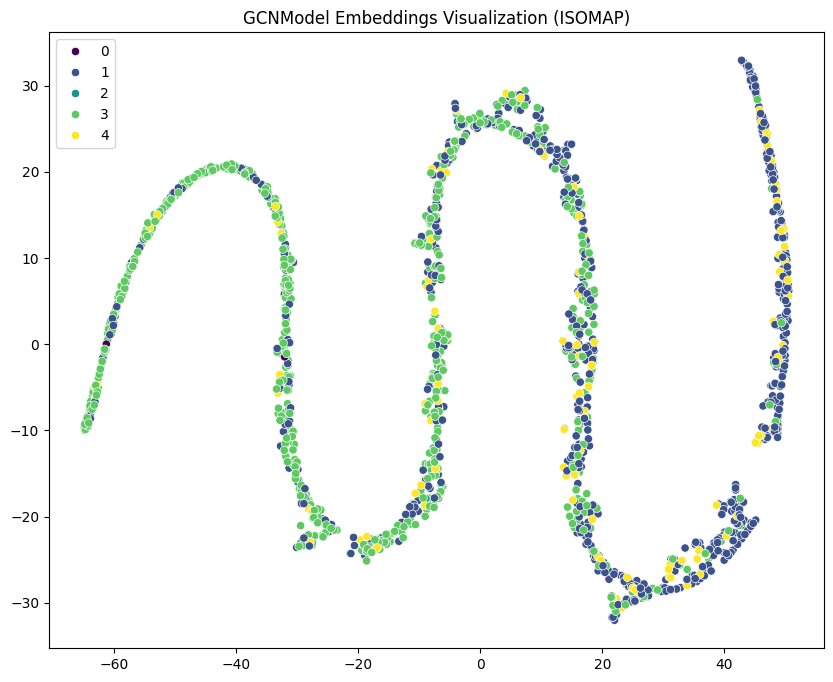

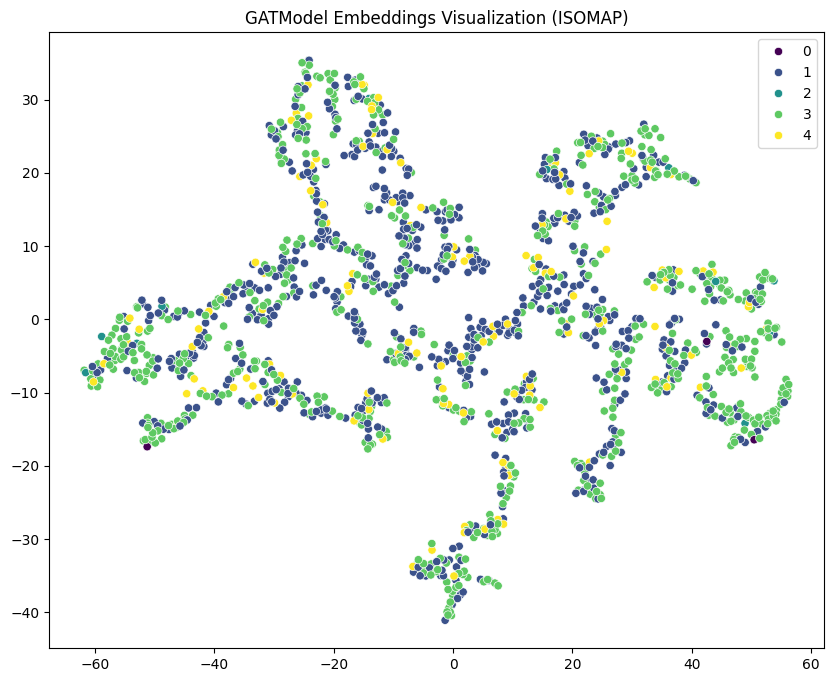

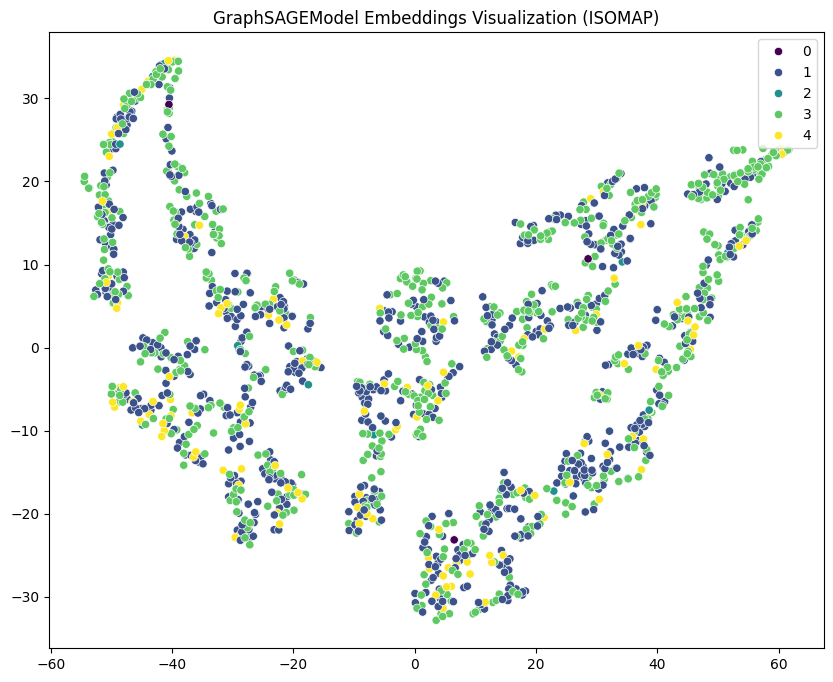

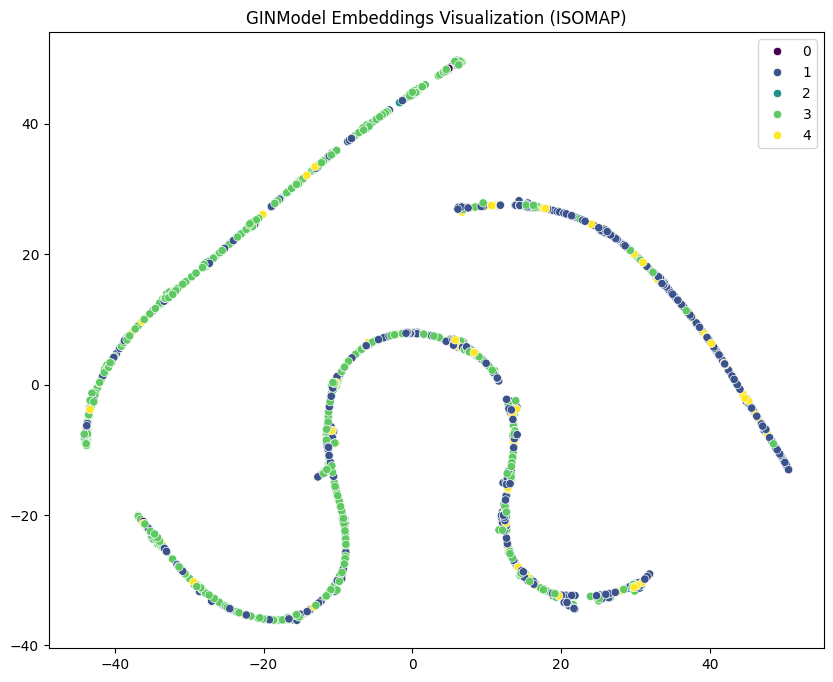

In [40]:
# dim reduction
for model_name, embeddings in model_manager.embeddings.items():
    valid_indices = data.train_mask | data.test_mask
    labels = data.y[valid_indices].cpu().numpy()
    reduced_embeddings = DimensionalityReducer.reduce_dimensions(
        embeddings[valid_indices], method="isomap"
    )
    EmbeddingVisualizer.visualize_embeddings(
        reduced_embeddings,
        labels,
        method="tsne",
        title=f"{model_name} Embeddings Visualization (ISOMAP)",
    )